In [1]:
import os
import json 

import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

import xarray as xr
import nc_time_axis

from SALib import ProblemSpec

from sobol_sa import wbm_sobol
from utils.global_paths import project_data_path, project_code_path
from utils.constants import location_names, location_coords, obs_colors, obs_names

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [19]:
# Set font
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [20]:
# For plots
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['text.usetex'] = False
plt.rcParams["font.size"] = 11
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

groups_ag = {'Soil': ['awCap', 'wiltingp'],
             'Snow': ['Tm', 'Ts'],
             'Evapotranspiration': ['alpha', 'c_lai', 'Kmax', 'Kmin', 'Kc_end', 'Kc_mid', 'Kc_ini'],
             'Growing Season': ['L_mid', 'L_dev', 'L_ini', 'GS_end', 'GS_start'],
             'Water': ['betaHBV']}

groups_nonag = {'Soil': ['awCap', 'wiltingp'],
                'Snow': ['Tm', 'Ts'],
                'Evapotranspiration': ['alpha', 'c_lai', 'Kmax', 'Kmin'],
                'Water': ['betaHBV']}

# Preliminaries

In [4]:
def store_params(param_dict, N, location):
    #########################
    # Problem spec for SAlib
    #########################
    param_names = list(param_dict.keys())
    n_params = len(param_names)

    # Check if done
    if not os.path.isfile(f"{project_data_path}/WBM/SA/{location}_params.txt"):
        sp = ProblemSpec({
            'num_vars': n_params,
            'names': param_names,
            'bounds': [param_dict[param] for param in param_names]
        }).sample_sobol(N)
    
        np.savetxt(f"{project_data_path}/WBM/SA/{location}_params.txt", sp.samples)
    else:
        print('Parameter file already exists!')

In [10]:
def sobol_bar_plot(location, obs_name, cc_info, metric, all_N, legend, color, title, ax):
    # Names
    param_name_dict = {'Ts':'$T_s$',
                       'Tm':'$T_m$',
                       'wiltingp':'$W_p$',
                       'awCap':'$W_{cap}$',
                       'alpha':r'$\alpha$',
                       'betaHBV':r'$\beta_R$',
                       'GS_start':'$GS_{start}$',
                       'GS_end':'$GS_{end}$',
                       'L_ini':'$L_{ini}$',
                       'L_dev':'$L_{dev}$',
                       'L_mid':'$L_{mid}$',
                       'Kc_ini':'$Kc_{ini}$',
                       'Kc_mid':'$Kc_{mid}$',
                       'Kc_end':'$Kc_{end}$',
                       'Kmin':'$K_{min}$',
                       'Kmax':'$K_{max}$',
                       'c_lai':'$c_{lai}$'}
    
    # Read
    if obs_name == "SMAP":
        df_main = pd.read_csv(f'{project_data_path}/WBM/SA/{location}_4096_{obs_name}_{cc_info}_res_total.csv')
        if all_N:
            df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{location}_1024_{obs_name}_{cc_info}_res_total.csv')
            df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{location}_2048_{obs_name}_{cc_info}_res_total.csv')
    else:
        df_main = pd.read_csv(f'{project_data_path}/WBM/SA/{location}_4096_NLDAS_{cc_info}_res_total.csv')
        if all_N:
            df_N1024 = pd.read_csv(f'{project_data_path}/WBM/SA/{location}_1024_NLDAS_{cc_info}_res_total.csv')
            df_N2048 = pd.read_csv(f'{project_data_path}/WBM/SA/{location}_2048_NLDAS_{cc_info}_res_total.csv')
    
    # Get params
    params = df_main['param'].unique()
    n_params = len(params)

    # Plot
    if all_N:
        colors = ['lightgray', 'darkgray', 'dimgray']
        for id, data in enumerate([df_N1024, df_N2048, df_main]):
            ax.barh(y=np.arange(id, (n_params*4) + id, 4),
                   width=data[data.metric == metric]['ST'],
                   xerr=data[data.metric == metric]['ST_conf'],
                   color=colors[id])

            # Tidy
            ax.set_yticks(np.arange(1, (n_params*4) + 1, 4), [param_name_dict[param] for param in params])

        if legend:
            # Legend
            custom_lines = [Line2D([0], [0], color=colors[2], lw=3),
                            Line2D([0], [0], color=colors[1], lw=3),
                            Line2D([0], [0], color=colors[0], lw=3)]
            ax.legend(custom_lines, ['N=4096', 'N=2048', 'N=1024'])
    else:
        ax.barh(y=np.arange(n_params),
                width=df_main[df_main.metric == metric]['ST'],
                xerr=df_main[df_main.metric == metric]['ST_conf'],
                color=color)
        ax.set_yticks(np.arange(n_params), [param_name_dict[param] for param in params])
        
    # Tidy
    ax.set_title(title)
    ax.grid(alpha=0.1)

In [26]:
def plot_timeseries(coords, obs_names_plot, plot_mean, plot_extrema, ax, legend, title):
    lat, lon = coords
    # Get location coordinates
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/eCONUS/SMAP/SMAP_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat

    # Get indices
    ix = (np.abs(lons - lon)).argmin().values
    iy = (np.abs(lats - lat)).argmin().values

    # x-axis
    time = xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')

    # Plot
    for obs_name in obs_names_plot:
        ds_tmp = np.load(f"{project_data_path}/WBM/calibration/eCONUS/{obs_name}/{obs_name}_validation.npy")
        ax.plot(time, ds_tmp[ix, iy, :], label=obs_name, color=obs_colors[obs_name])
        if plot_mean:
            ax.axhline(np.mean(ds_tmp[ix, iy, :]), color=obs_colors[obs_name], ls='--')
        if plot_extrema:
            ax.scatter(time[np.argmax(ds_tmp[ix, iy, :])], np.max(ds_tmp[ix, iy, :]), color=obs_colors[obs_name])
            ax.scatter(time[np.argmin(ds_tmp[ix, iy, :])], np.min(ds_tmp[ix, iy, :]), color=obs_colors[obs_name])
    
    # Tidy
    if legend:
        ax.legend()

    if title:
        ax.set_title(title, style='italic', loc='left', fontsize=11)
        
    ax.grid()
    ax.set_ylabel('Soil moisture [mm]')

In [27]:
def make_sobol_plot_normalized(location, ax, title, colors):
    obs_names = ['SMAP', 'NLDAS']
    
    # Read all
    df = []
    for obs in obs_names:
        df_tmp = pd.read_csv(f'{project_data_path}/WBM/SA/{location}_4096_{obs}_noCC_res_total.csv')
        df_tmp = df_tmp.replace('mean', f'mean_{obs}')
        df_tmp = df_tmp.replace('sd', f'sd_{obs}')
        df_tmp = df_tmp.replace('range', f'range_{obs}')
        df.append(df_tmp)

    df = pd.concat(df)

    # Get params
    params = df['param'].unique()

    # Select and normalize
    df_plot = df[df['metric'].isin(metrics_to_include)]
    df_plot["ST_norm"] = df_plot["ST"] / df_plot.groupby("metric")["ST"].transform("sum")
    df_plot = df_plot.pivot(index='metric', columns='param', values='ST_norm')[params]
    df_plot = df_plot.reindex(metrics_to_include[::-1])

    # Plot
    df_plot.plot.barh(stacked=True, legend=False, ax=ax, color=colors)
    
    ax.set_yticklabels(ylabels[::-1])
    ax.set_ylabel('')
    ax.set_xlabel('Total order sobol index (normalized)')
    ax.set_xlim([0,1])

    if title:
        ax.set_title(title, style='italic', loc='left', fontsize=11)

# Locations

## McLean county

### Compute

In [7]:
location = "mclean"
lat, lon = location_coords[location]

In [8]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

290
124


In [9]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.4384635315014632
cotton: 0.0
rice: 0.0
sorghum: 9.26961986387762e-05
soybeans: 0.43160019027853863
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.11623816620028393
water: 0.0
evergreen_needleleaf: 0.0
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.006802720949053764
wooded_grassland: 0.006802720949053764
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.0
barren: 0.0
urban: 0.0


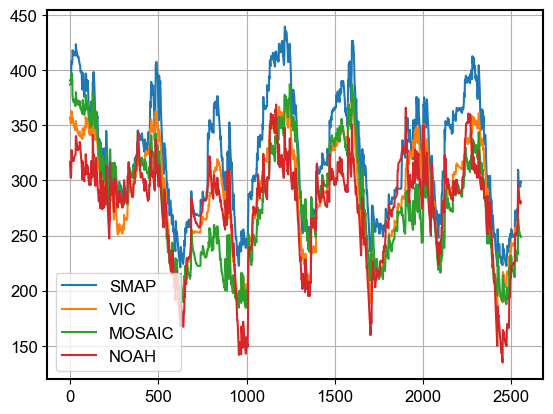

In [10]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [11]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [50, 250] # Wilting point [mm]
param_dict['awCap'] = [200, 400] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize/soy)
param_dict['GS_start'] = [60, 152] 
param_dict['GS_end'] = [244, 334] 
param_dict['L_ini'] = [0.07, 0.22] 
param_dict['L_dev'] = [0.18, 0.33] 
param_dict['L_mid'] = [0.13, 0.38] 
param_dict['Kc_ini'] = [0.1, 0.5] 
param_dict['Kc_mid'] = [1., 1.5] 
param_dict['Kc_end'] = [0.2, 0.6] 
param_dict['Kmin'] = param_dict['Kc_ini']
param_dict['Kmax'] = param_dict['Kc_mid']
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{location}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{location}_1024")
store_params(param_dict, 2048, f"{location}_2048")
store_params(param_dict, 4096, f"{location}_4096")

Parameter file already exists!
Parameter file already exists!
Parameter file already exists!


In [12]:
%%time
# RUN IT
# Historical
for obs_name in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{location}_{str(N)}_{obs_name}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res_total.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            if N == 4096:
                store_sims = True
            else:
                store_sims = False
                
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs_name, eval=obs_name,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=location,
                      Kpet_name = "crop",
                      N=N, 
                      store_sims=store_sims, 
                      save_name=save_name)
            print(save_name)

mclean_1024_SMAP_noCC already done
mclean_2048_SMAP_noCC already done
mclean_4096_SMAP_noCC already done
mclean_1024_NLDAS_noCC already done
mclean_2048_NLDAS_noCC already done
mclean_4096_NLDAS_noCC already done
CPU times: user 766 μs, sys: 0 ns, total: 766 μs
Wall time: 4.06 ms


In [13]:
%%time
# RUN IT
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 2, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{location}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res_total.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    if N == 4096:
                        store_sims = True
                    else:
                        store_sims = False
                
                    wbm_sobol(ix=ix,
                              iy=iy,
                              forcing=obs,
                              eval=None,
                              tas_delta=tas_delta, prcp_factor=prcp_factor,
                              experiment_name=location,
                              Kpet_name="crop",
                              N=N, 
                              store_sims = store_sims,
                              save_name=save_name)
                    print(save_name)

mclean_1024_SMAP_CCtas-5prcp0.5 already done
mclean_1024_SMAP_CCtas-5prcp0.9 already done
mclean_1024_SMAP_CCtas-5prcp1.1 already done
mclean_1024_SMAP_CCtas-5prcp1.5 already done
mclean_1024_SMAP_CCtas2prcp0.5 already done
mclean_1024_SMAP_CCtas2prcp0.9 already done
mclean_1024_SMAP_CCtas2prcp1.1 already done
mclean_1024_SMAP_CCtas2prcp1.5 already done
mclean_1024_SMAP_CCtas5prcp0.5 already done
mclean_1024_SMAP_CCtas5prcp0.9 already done
mclean_1024_SMAP_CCtas5prcp1.1 already done
mclean_1024_SMAP_CCtas5prcp1.5 already done
mclean_1024_SMAP_CCtas10prcp0.5 already done
mclean_1024_SMAP_CCtas10prcp0.9 already done
mclean_1024_SMAP_CCtas10prcp1.1 already done
mclean_1024_SMAP_CCtas10prcp1.5 already done
mclean_2048_SMAP_CCtas-5prcp0.5 already done
mclean_2048_SMAP_CCtas-5prcp0.9 already done
mclean_2048_SMAP_CCtas-5prcp1.1 already done
mclean_2048_SMAP_CCtas-5prcp1.5 already done
mclean_2048_SMAP_CCtas2prcp0.5 already done
mclean_2048_SMAP_CCtas2prcp0.9 already done
mclean_2048_SMAP_CCt

### Plots

In [7]:
location = "mclean"
lat, lon = location_coords[location]

/storage/work/dcl5300/current_projects/wbm_soilM_uc_2024/code/utils/grouped_radial.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  angle = math.atan((y[j]-y[i])/(x[j]-x[i]))


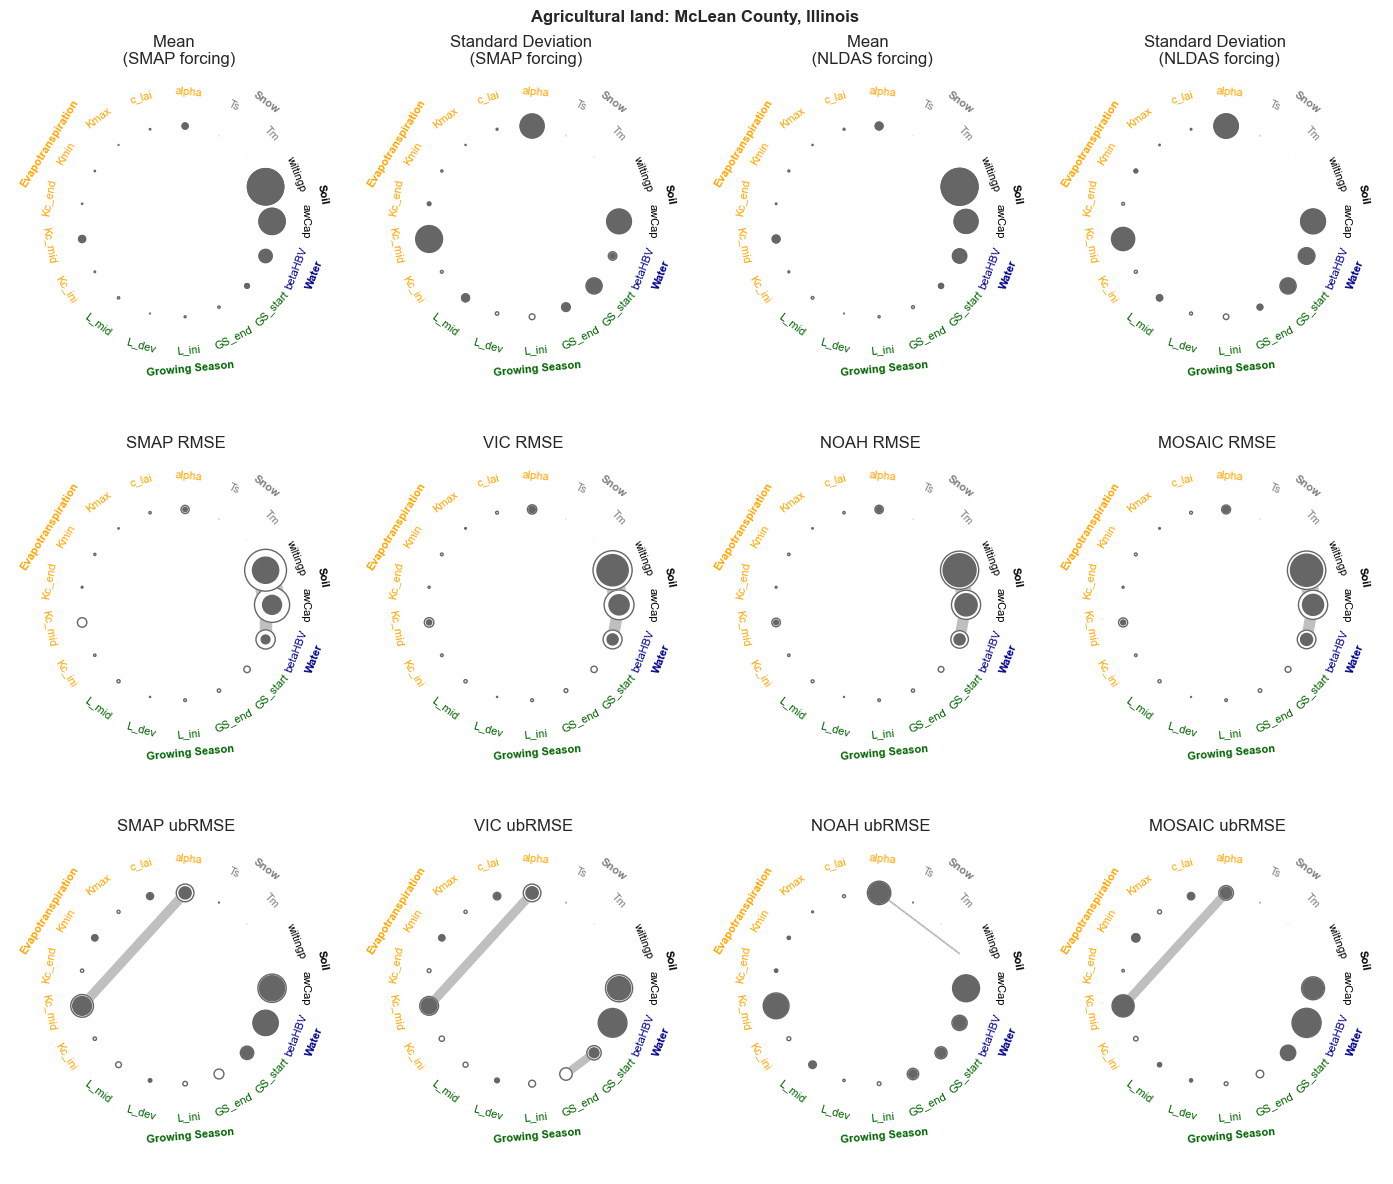

In [8]:
from utils.grouped_radial import plot_second_order_all
plot_second_order_all(location, groups_ag, 4096, True)

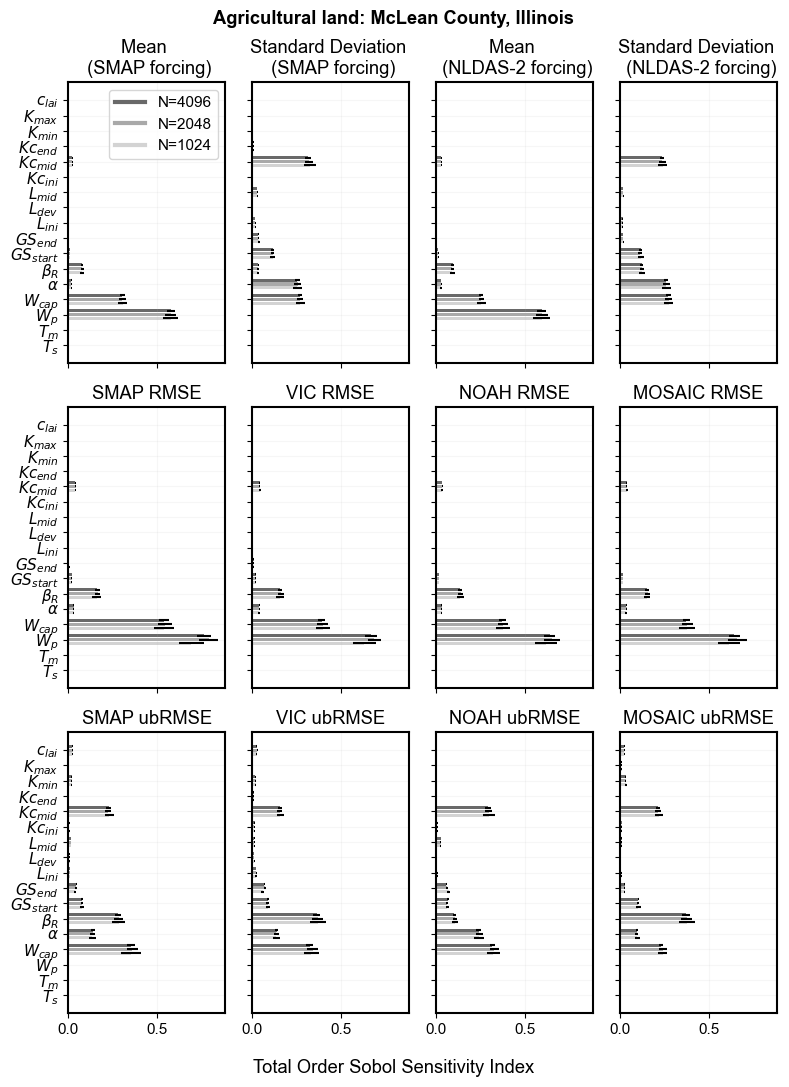

In [8]:
# Historical
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,11), sharey=True, sharex=True)

# Top row
sobol_bar_plot(location, "SMAP", "noCC", "mean", True, True, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
sobol_bar_plot(location, "SMAP", "noCC", "sd", True, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
sobol_bar_plot(location, "NLDAS", "noCC", "mean", True, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
sobol_bar_plot(location, "NLDAS", "noCC", "sd", True, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    sobol_bar_plot(location, obs_name, "noCC", f"rmse_{obs_name}",True, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    sobol_bar_plot(location, obs_name, "noCC", f"ubrmse_{obs_name}",True, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle(location_names[location], fontweight='bold')

plt.tight_layout()

plt.savefig(f'{project_code_path}/figs/si/{location}_sobol_noCC.pdf')

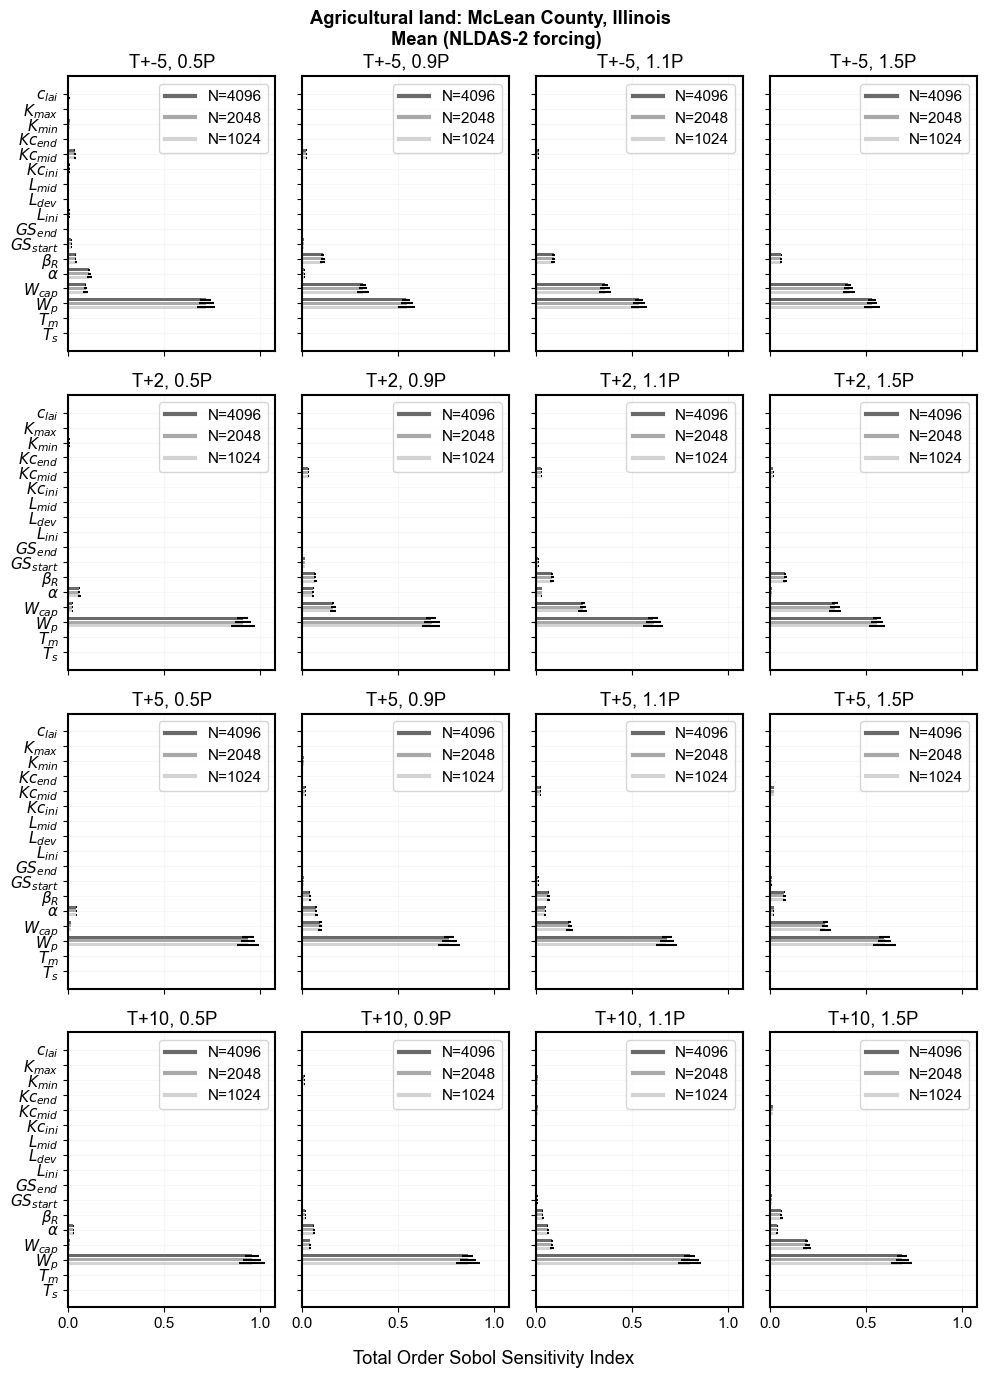

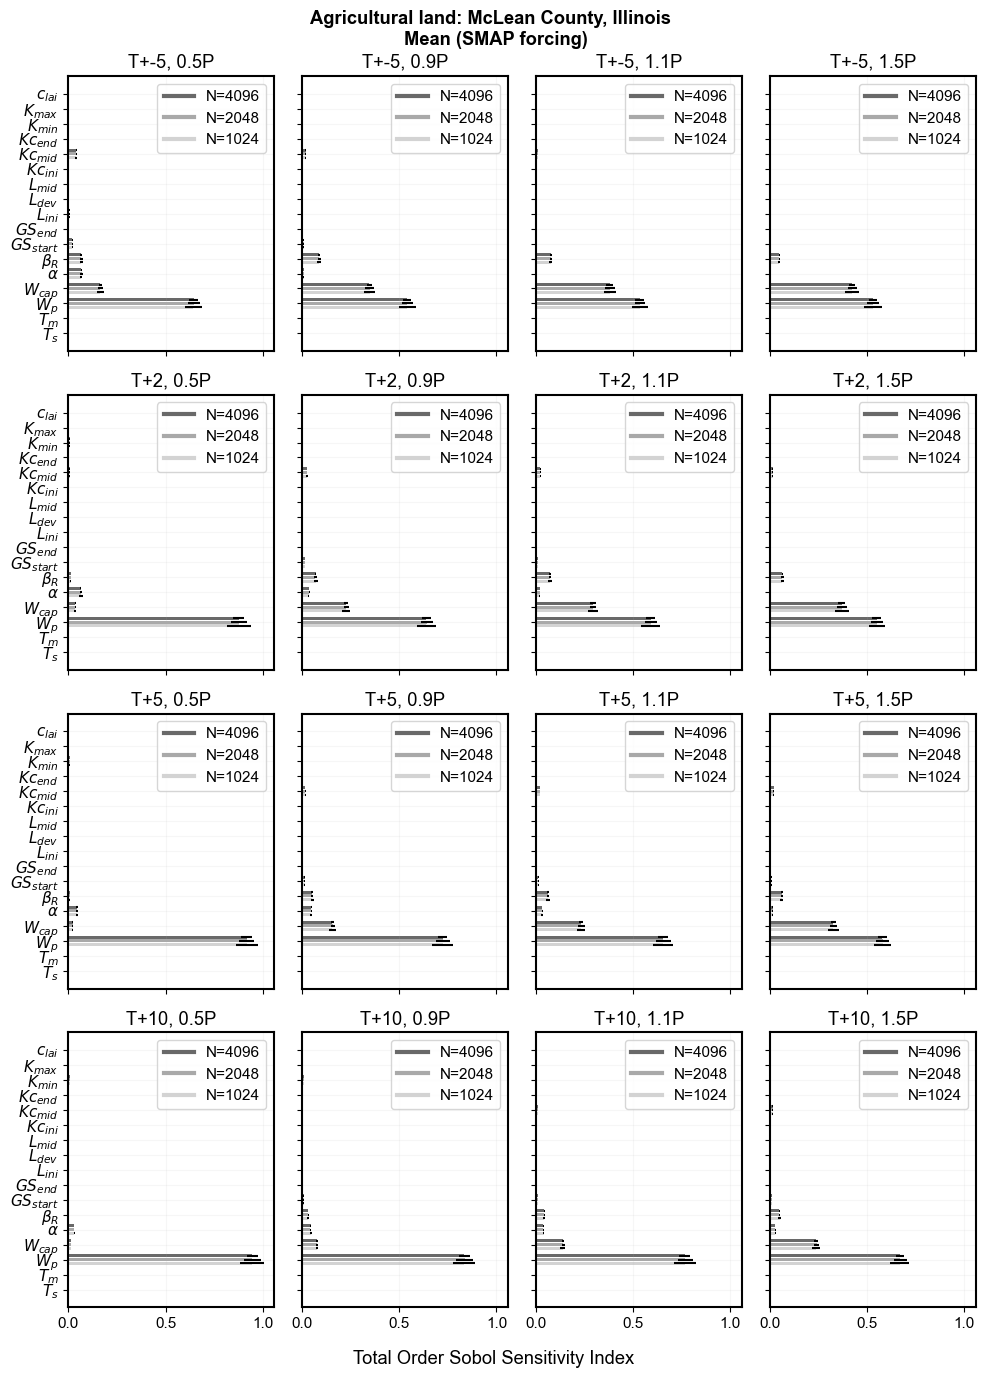

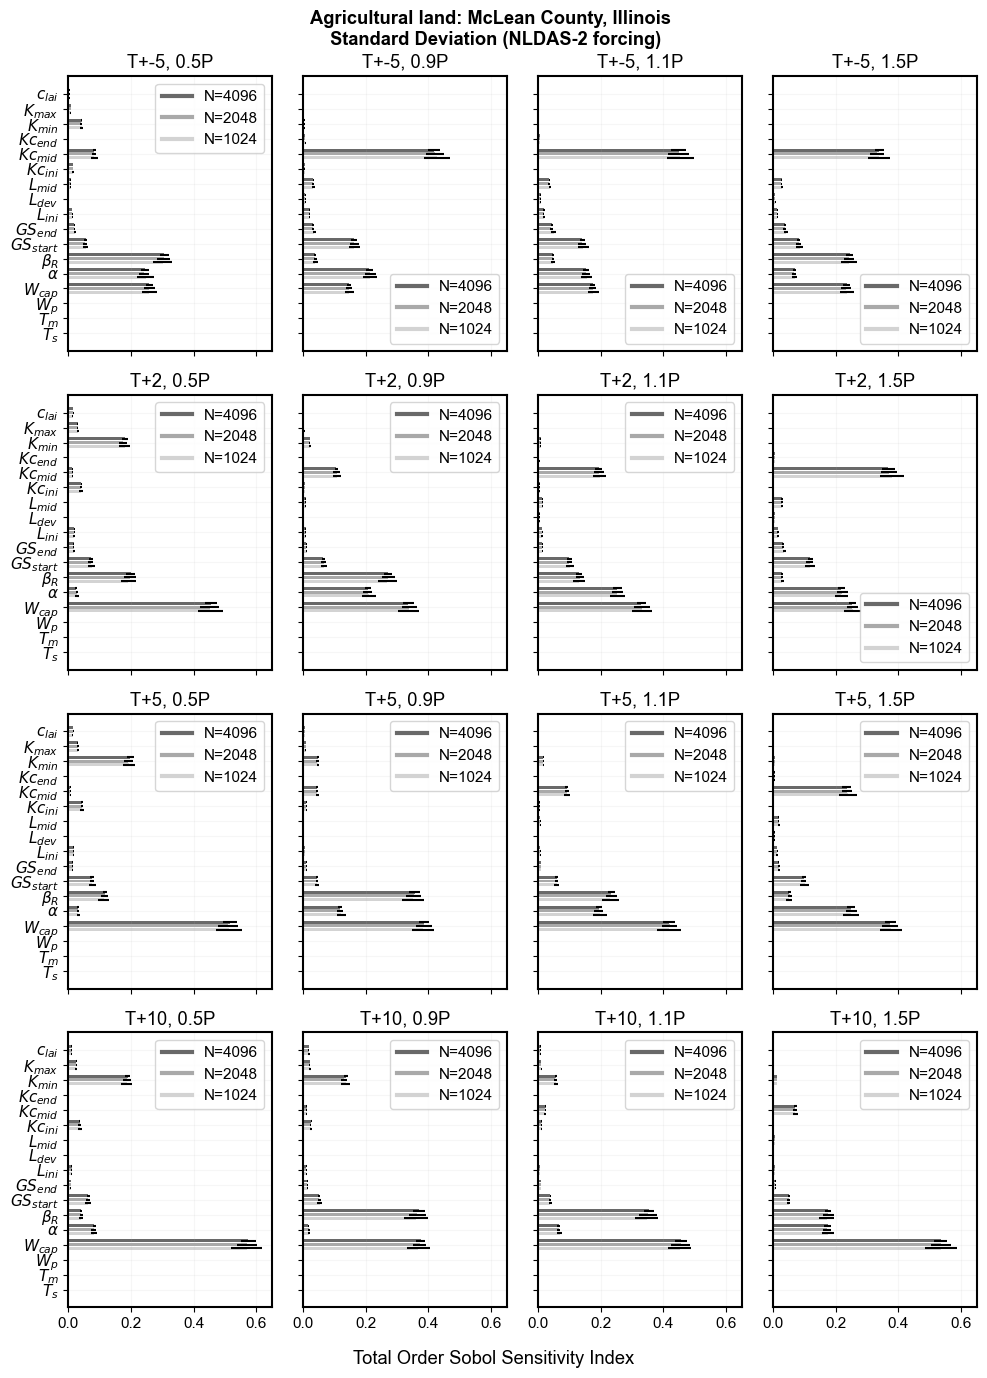

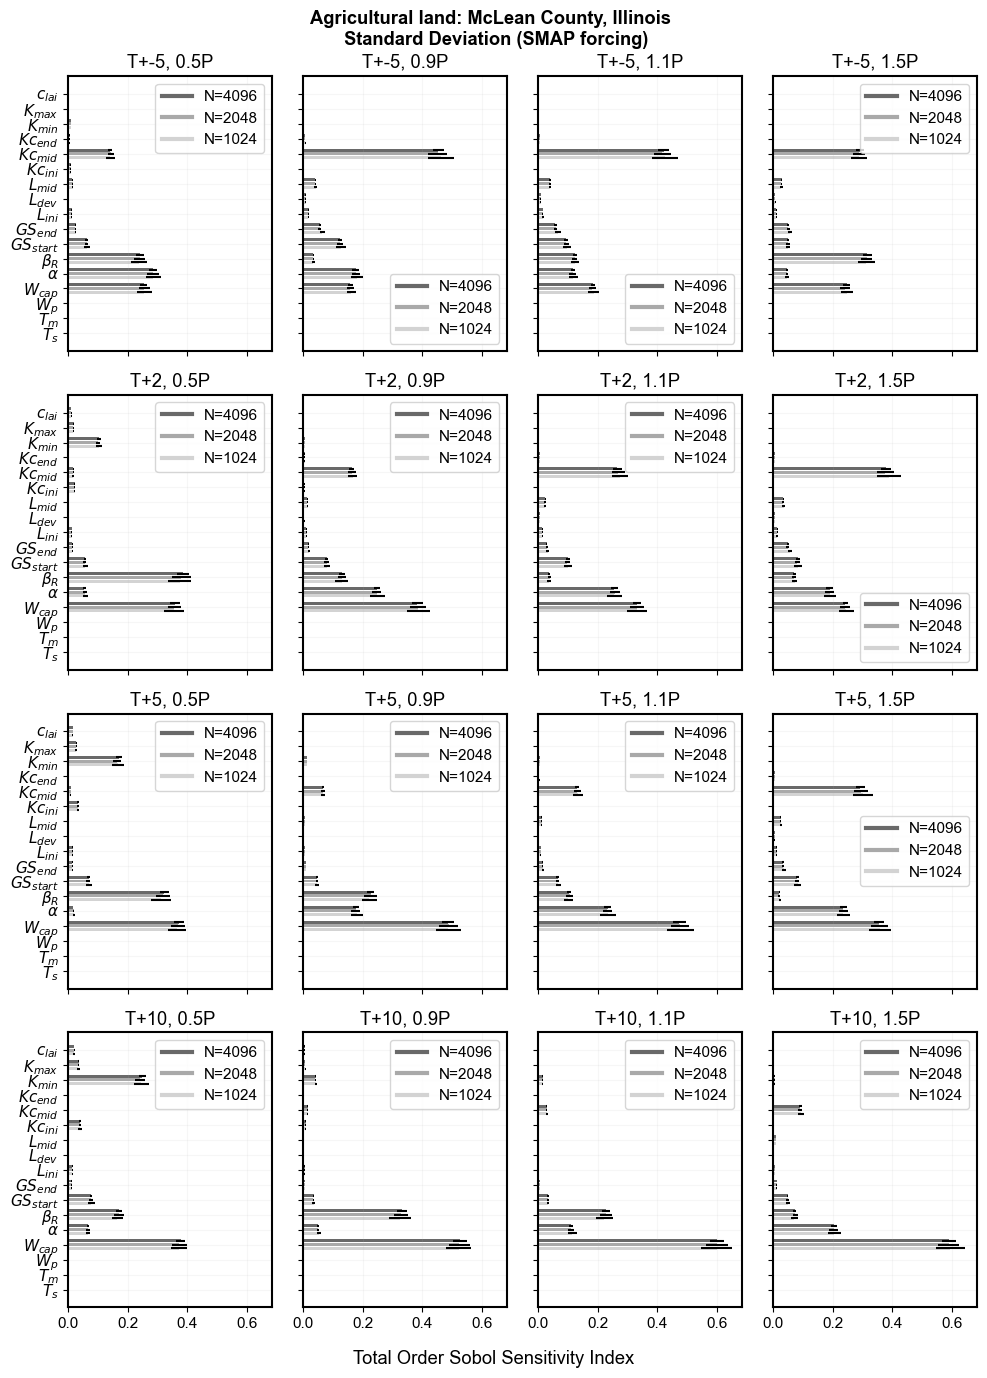

In [9]:
# Future
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

# Loop through metric/obs combos
for metric in ["mean", "sd"]:
    for obs_name in obs_name_dict.keys():
        # Make figure
        fig, axs = plt.subplots(4,4, figsize=(10,14), sharey=True, sharex=True)

        for idt, tas_delta in enumerate([-5, 2, 5, 10]):
            for idp, prcp_factor in enumerate([0.5, 0.9, 1.1, 1.5]):
                sobol_bar_plot(location, obs_name, f"CCtas{tas_delta}prcp{prcp_factor}", metric, True, True, None, f"T+{tas_delta}, {prcp_factor}P", axs[idt, idp])

        fig.supxlabel('Total Order Sobol Sensitivity Index')
        fig.suptitle(f"{location_names[location]} \n {metric_name_dict[metric]} ({obs_name_dict[obs_name]} forcing)", fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'{project_code_path}/figs/si/{location}_sobol_CC_{obs_name}_{metric}.pdf')

/tmp/ipykernel_3879579/2244230319.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3879579/2244230319.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location}_hindcast_stats.png', dpi=600)
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


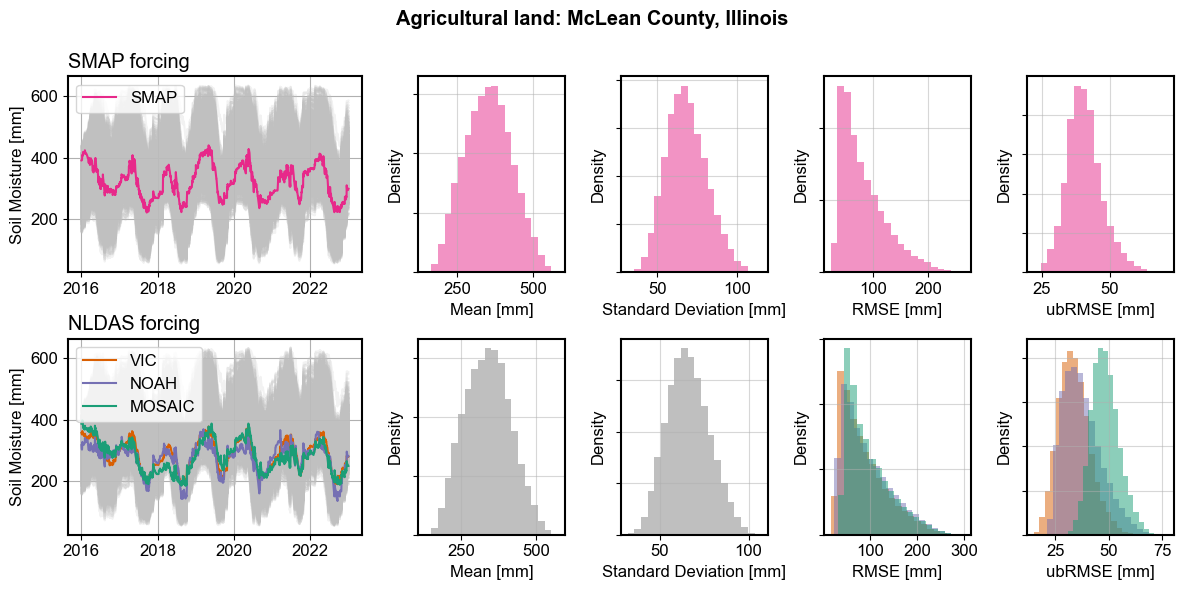

In [17]:
# Timeseries and summary stats

# Read data
npz_smap = np.load(f"{project_data_path}/WBM/SA/{location}_4096_SMAP_noCC_sim_stats.npz")
npz_nldas = np.load(f"{project_data_path}/WBM/SA/{location}_4096_NLDAS_noCC_sim_stats.npz")

smap_sims = npz_smap['sims']
nldas_sims = npz_nldas['sims']

# Plot details
times = xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')
stat_name_dict = {'mean':'Mean [mm]', 'sd':'Standard Deviation [mm]', 'rmse': 'RMSE [mm]', 'ubrmse': 'ubRMSE [mm]'}

# Start plot
fig, axs = plt.subplots(2, 5, figsize=(12,6), width_ratios = [2,1,1,1,1])
fig.suptitle(location_names[location], fontweight='bold')

## SMAP
# Timeseries
ax = axs[0,0]
ax.set_title('SMAP forcing', loc='left')
for i in range(1, smap_sims.shape[0], 100):
    ax.plot(times, smap_sims[i, :], color='silver', alpha=0.2)

plot_timeseries(location_coords[location], ['SMAP'], False, False, ax, True)

# Stats
for ids, stat in enumerate(['mean', 'sd', 'rmse', 'ubrmse']):
    ax = axs[0,1+ids]
    data = npz_smap[f'SMAP_{stat}'] if 'rmse' in stat else npz_smap[stat]
    ax.hist(data, bins=20, color=obs_colors['SMAP'], alpha=0.5)
    ax.set_xlabel(stat_name_dict[stat])
    ax.set_ylabel('Density')
    ax.set_yticklabels('')
    ax.grid(alpha=0.5)
    
## NLDAS
# Timeseries
ax = axs[1,0]
ax.set_title('NLDAS forcing', loc='left')
for i in range(1, nldas_sims.shape[0], 100):
    ax.plot(times, nldas_sims[i, :], color='silver', alpha=0.2)

obs_to_plot = ['VIC', 'NOAH', 'MOSAIC']
plot_timeseries(location_coords[location], obs_to_plot, False, False, ax, True)

# Stats
for ids, stat in enumerate(['mean', 'sd']):
    ax = axs[1,1+ids]
    ax.hist(npz_nldas[stat], bins=20, alpha=0.5, color='gray')
    ax.set_xlabel(stat_name_dict[stat])
    ax.set_ylabel('Density')
    ax.set_yticklabels('')
    ax.grid(alpha=0.5)
        
for ids, stat in enumerate(['rmse', 'ubrmse']):
    for obs_name in obs_to_plot:
        ax = axs[1,3+ids]
        ax.hist(npz_nldas[f'{obs_name}_{stat}'], bins=20, alpha=0.5, color=obs_colors[obs_name])
        ax.set_xlabel(stat_name_dict[stat])
        ax.set_ylabel('Density')
        ax.set_yticklabels('')
        ax.grid(alpha=0.5)
        
plt.tight_layout()
plt.savefig(f'../figs/si/{location}_hindcast_stats.png', dpi=600)

## Smoky Mountains

### Compute

In [18]:
location = "smoky"
lat, lon = location_coords[location]

In [19]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

330
84


In [20]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.0
cotton: 0.0
rice: 0.0
sorghum: 0.0
soybeans: 0.0
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.0
water: 0.0
evergreen_needleleaf: 0.012658228166401386
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.9303797483444214
mixed_forest: 0.0569620244204998
woodland: 0.0
wooded_grassland: 0.0
closed_shurbland: 0.0
open_shrubland: 0.0
grassland: 0.0
barren: 0.0
urban: 0.0


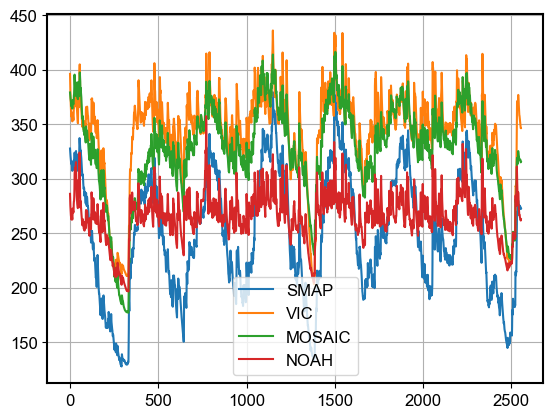

In [21]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [22]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [50, 250] # Wilting point [mm]
param_dict['awCap'] = [150, 300] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc params
param_dict['Kmin'] = [0.1, 0.75]
param_dict['Kmax'] = [0.75, 1.5]
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{location}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{location}_1024")
store_params(param_dict, 2048, f"{location}_2048")
store_params(param_dict, 4096, f"{location}_4096")

Parameter file already exists!
Parameter file already exists!
Parameter file already exists!


In [23]:
%%time
# RUN IT
# Historical
for obs_name in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{location}_{str(N)}_{obs_name}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res_total.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            if N == 4096:
                store_sims = True
            else:
                store_sims = False
                
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs_name, eval=obs_name,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=location,
                      Kpet_name = "gen",
                      N=N, 
                      store_sims=store_sims, 
                      save_name=save_name)
            print(save_name)

smoky_1024_SMAP_noCC already done
smoky_2048_SMAP_noCC already done
smoky_4096_SMAP_noCC already done
smoky_1024_NLDAS_noCC already done
smoky_2048_NLDAS_noCC already done
smoky_4096_NLDAS_noCC already done
CPU times: user 784 μs, sys: 30 μs, total: 814 μs
Wall time: 3 ms


In [30]:
%%time
# RUN IT
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 2, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{location}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res_total.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    if N == 4096:
                        store_sims = True
                    else:
                        store_sims = False
                
                    wbm_sobol(ix=ix,
                              iy=iy,
                              forcing=obs,
                              eval=None,
                              tas_delta=tas_delta, prcp_factor=prcp_factor,
                              experiment_name=location,
                              Kpet_name="gen",
                              N=N, 
                              store_sims = store_sims,
                              save_name=save_name)
                    print(save_name)

/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_SMAP_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_SMAP_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_SMAP_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_1024_NLDAS_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_2048_NLDAS_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


smoky_4096_NLDAS_CCtas10prcp1.5
CPU times: user 1h 21min 13s, sys: 4min 11s, total: 1h 25min 24s
Wall time: 1h 26min 46s


### Plots

In [17]:
location = "smoky"
lat, lon = location_coords[location]

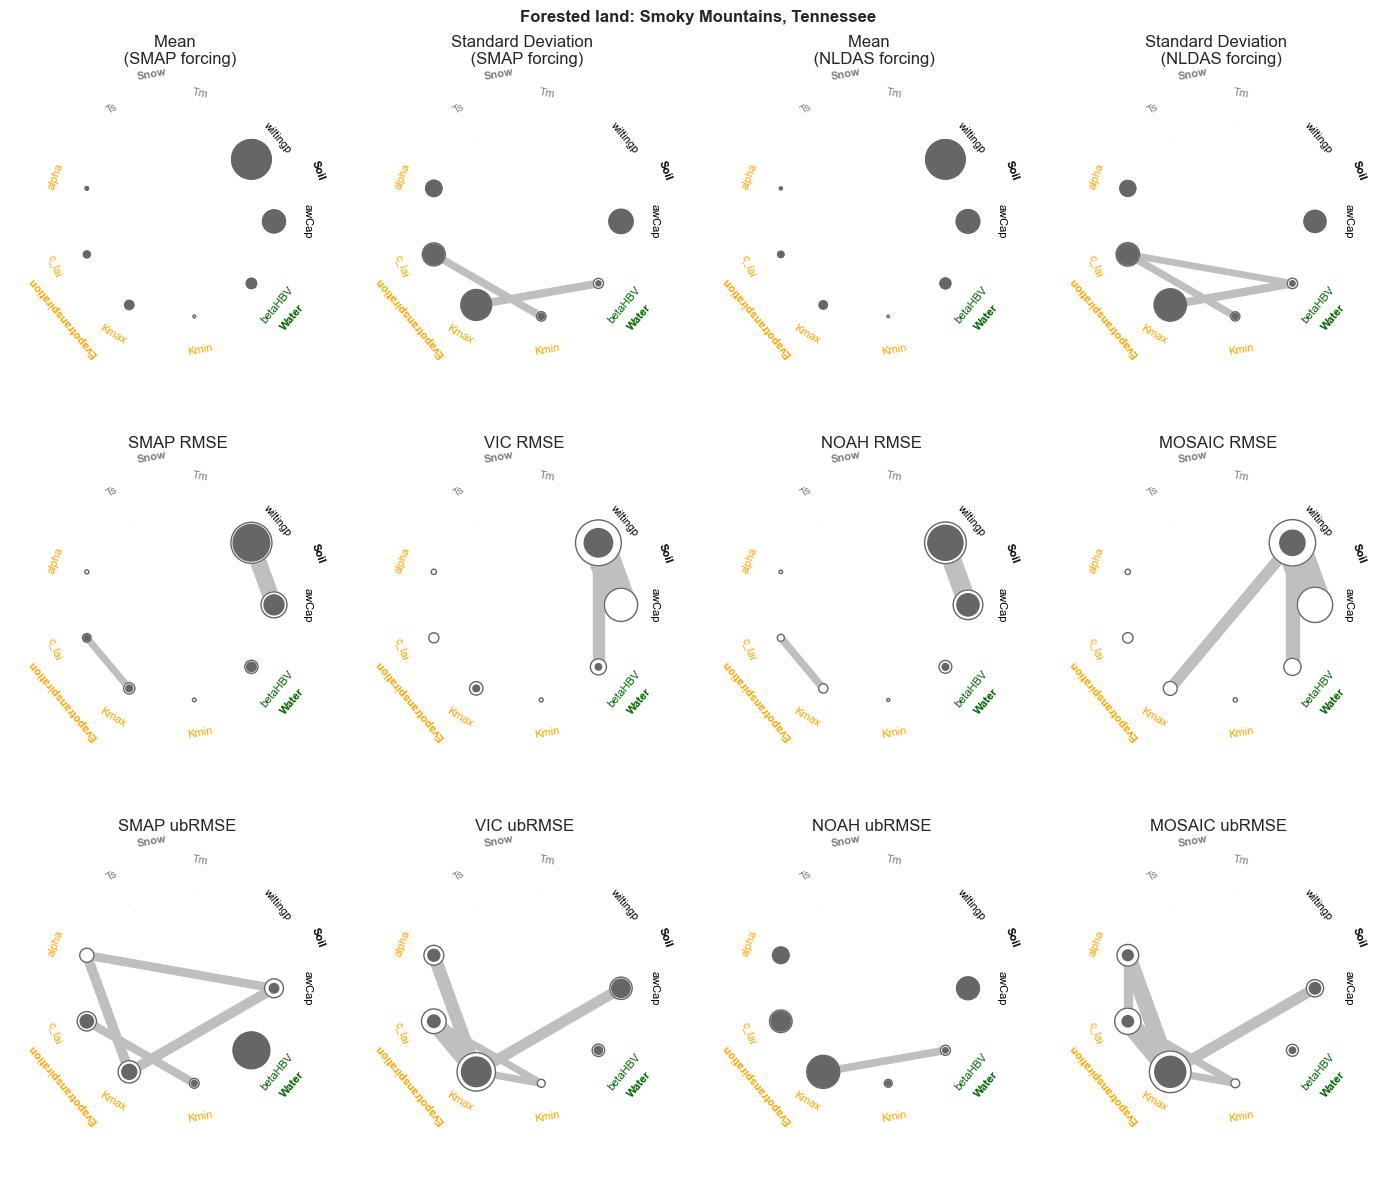

In [18]:
from utils.grouped_radial import plot_second_order_all

plot_second_order_all(location, groups_nonag, 4096, True)

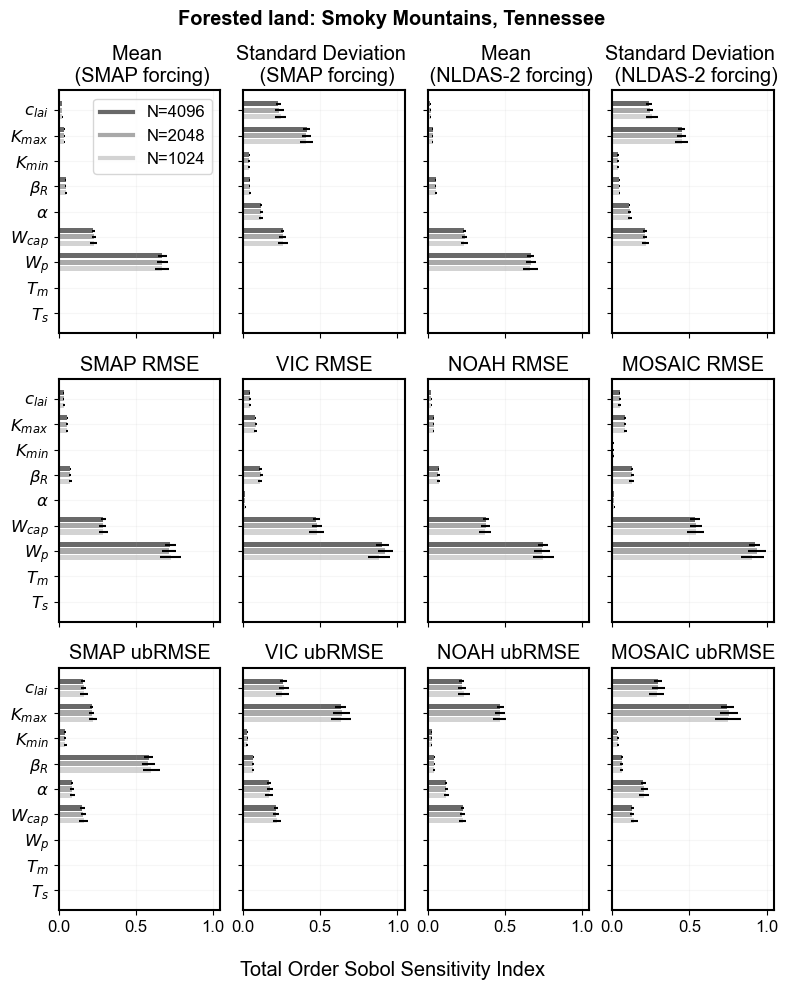

In [32]:
# Historical
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
sobol_bar_plot(location, "SMAP", "noCC", "mean", True, True, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
sobol_bar_plot(location, "SMAP", "noCC", "sd", True, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
sobol_bar_plot(location, "NLDAS", "noCC", "mean", True, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
sobol_bar_plot(location, "NLDAS", "noCC", "sd", True, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    sobol_bar_plot(location, obs_name, "noCC", f"rmse_{obs_name}",True, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    sobol_bar_plot(location, obs_name, "noCC", f"ubrmse_{obs_name}",True, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle(location_names[location], fontweight='bold')

plt.tight_layout()

plt.savefig(f'{project_code_path}/figs/si/{location}_sobol_noCC.pdf')

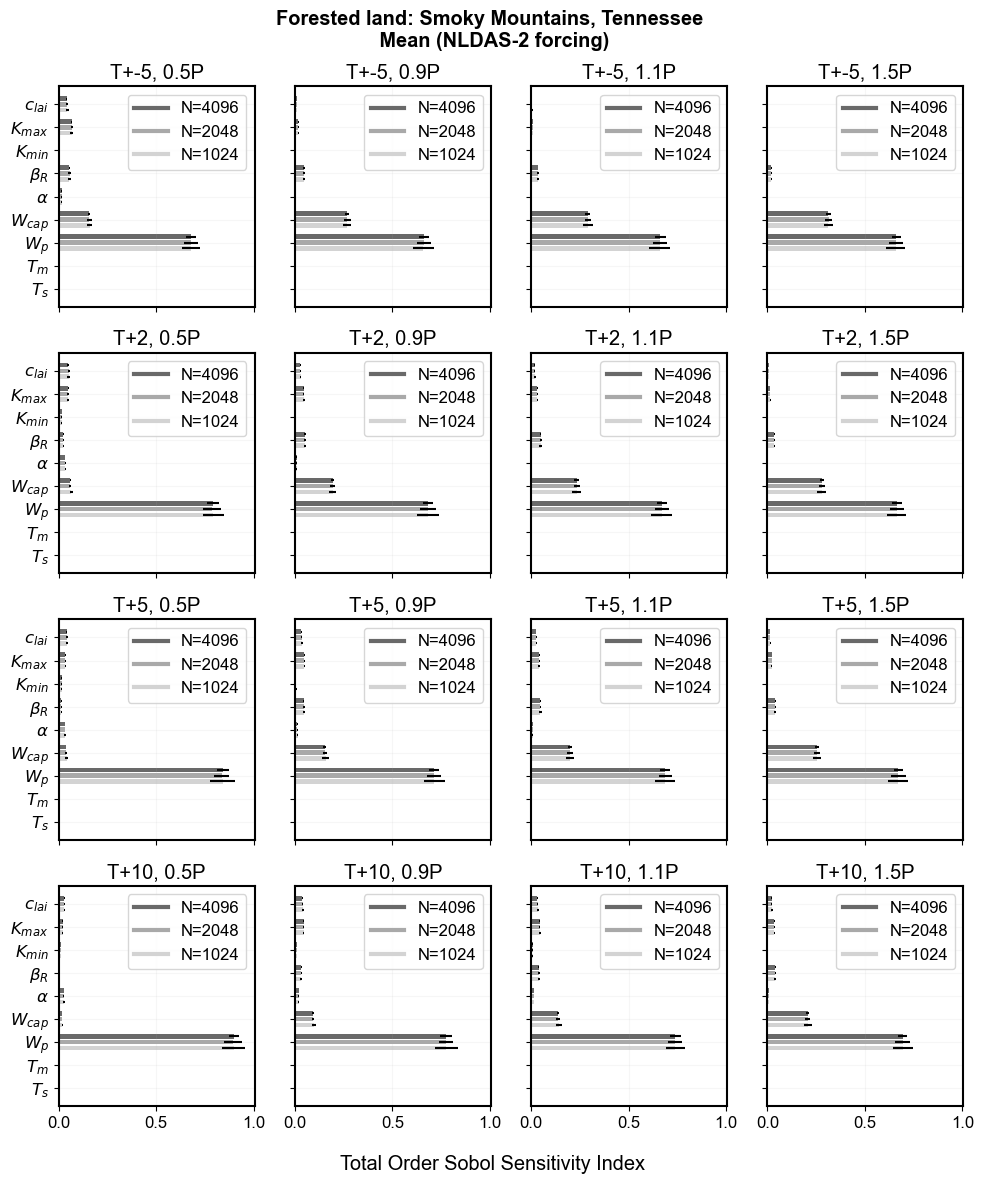

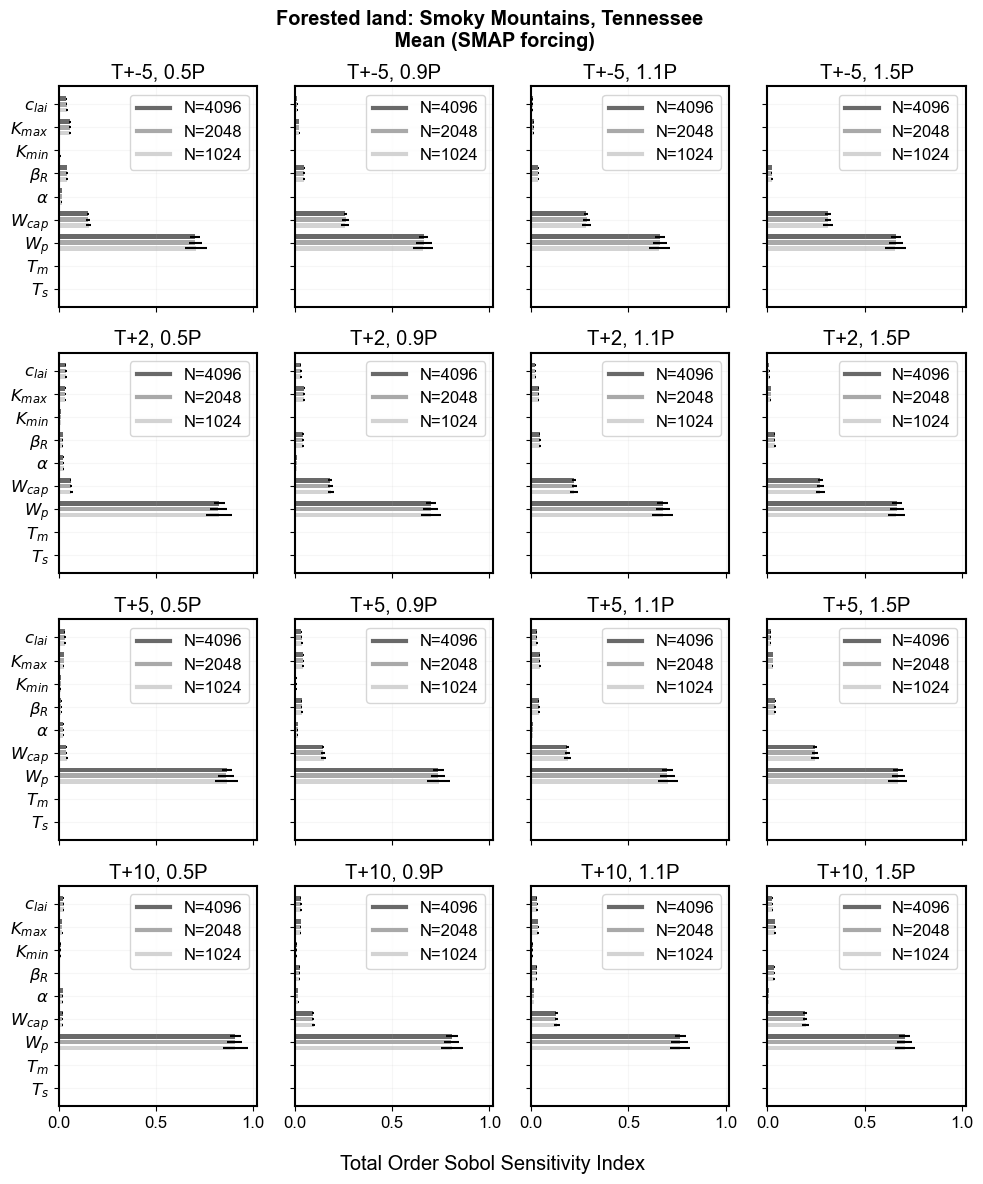

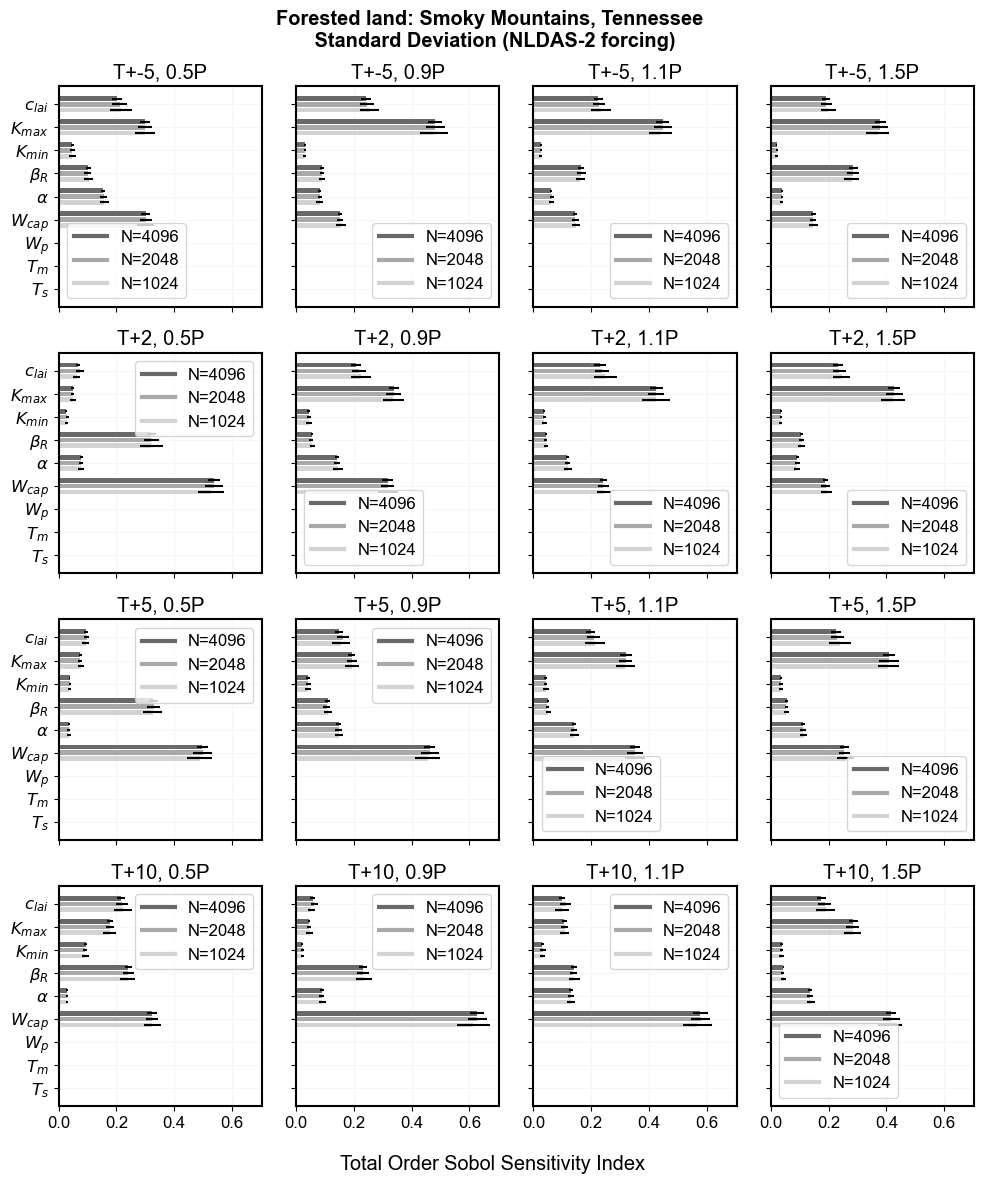

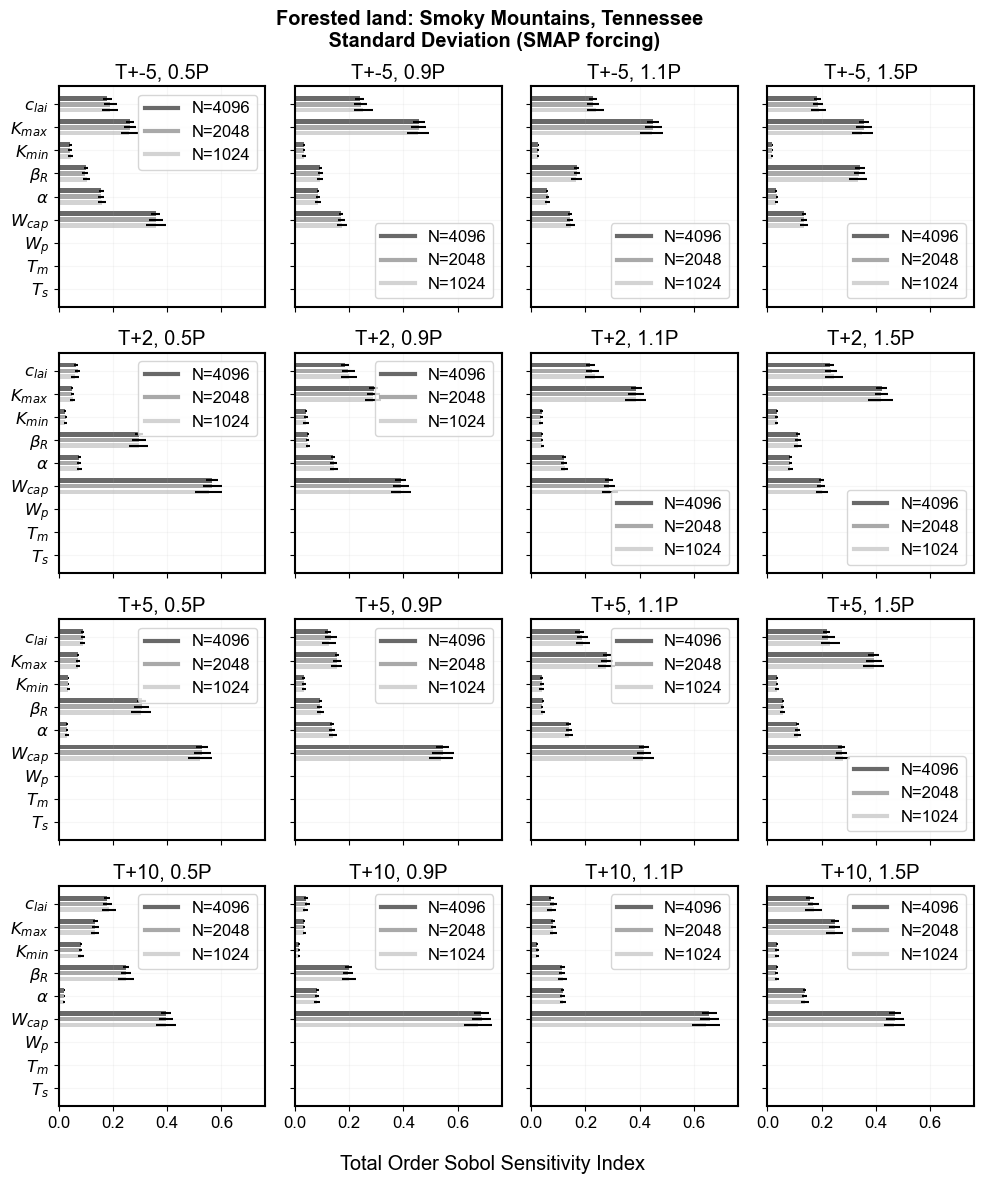

In [33]:
# Future
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

# Loop through metric/obs combos
for metric in ["mean", "sd"]:
    for obs_name in obs_name_dict.keys():
        # Make figure
        fig, axs = plt.subplots(4,4, figsize=(10,12), sharey=True, sharex=True)

        for idt, tas_delta in enumerate([-5, 2, 5, 10]):
            for idp, prcp_factor in enumerate([0.5, 0.9, 1.1, 1.5]):
                sobol_bar_plot(location, obs_name, f"CCtas{tas_delta}prcp{prcp_factor}", metric, True, True, None, f"T+{tas_delta}, {prcp_factor}P", axs[idt, idp])

        fig.supxlabel('Total Order Sobol Sensitivity Index')
        fig.suptitle(f"{location_names[location]} \n {metric_name_dict[metric]} ({obs_name_dict[obs_name]} forcing)", fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'{project_code_path}/figs/si/{location}_sobol_CC_{obs_name}_{metric}.pdf')

/tmp/ipykernel_3879579/2244230319.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3879579/2244230319.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location}_hindcast_stats.png', dpi=600)
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


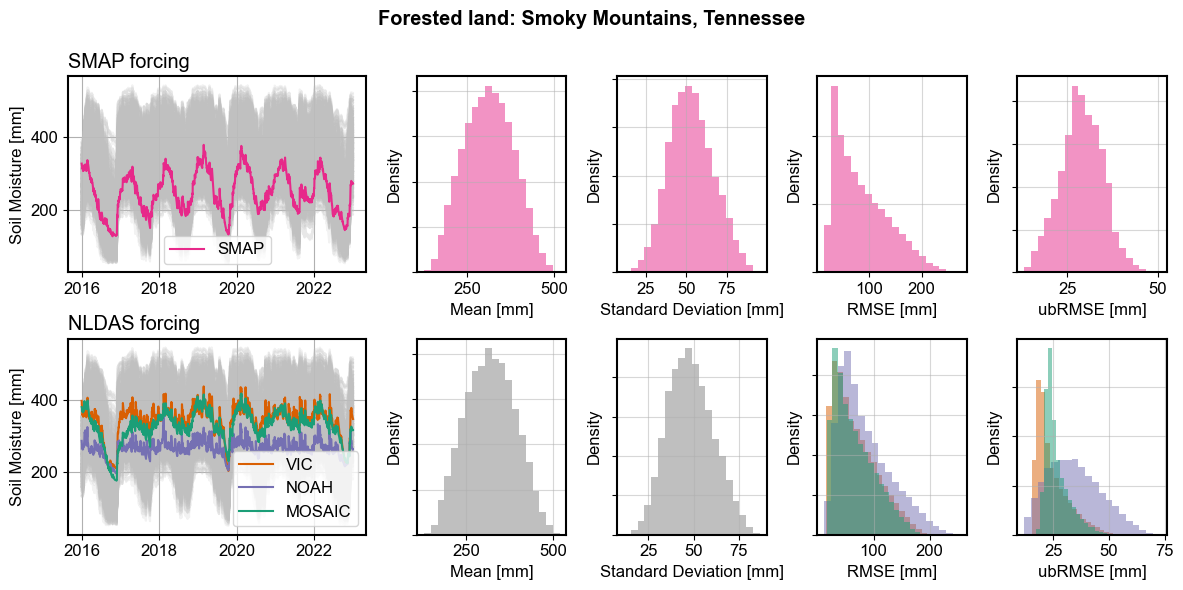

In [34]:
# Timeseries and summary stats

# Read data
npz_smap = np.load(f"{project_data_path}/WBM/SA/{location}_4096_SMAP_noCC_sim_stats.npz")
npz_nldas = np.load(f"{project_data_path}/WBM/SA/{location}_4096_NLDAS_noCC_sim_stats.npz")

smap_sims = npz_smap['sims']
nldas_sims = npz_nldas['sims']

# Plot details
times = xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')
stat_name_dict = {'mean':'Mean [mm]', 'sd':'Standard Deviation [mm]', 'rmse': 'RMSE [mm]', 'ubrmse': 'ubRMSE [mm]'}

# Start plot
fig, axs = plt.subplots(2, 5, figsize=(12,6), width_ratios = [2,1,1,1,1])
fig.suptitle(location_names[location], fontweight='bold')

## SMAP
# Timeseries
ax = axs[0,0]
ax.set_title('SMAP forcing', loc='left')
for i in range(1, smap_sims.shape[0], 100):
    ax.plot(times, smap_sims[i, :], color='silver', alpha=0.2)

plot_timeseries(location_coords[location], ['SMAP'], False, False, ax, True)

# Stats
for ids, stat in enumerate(['mean', 'sd', 'rmse', 'ubrmse']):
    ax = axs[0,1+ids]
    data = npz_smap[f'SMAP_{stat}'] if 'rmse' in stat else npz_smap[stat]
    ax.hist(data, bins=20, color=obs_colors['SMAP'], alpha=0.5)
    ax.set_xlabel(stat_name_dict[stat])
    ax.set_ylabel('Density')
    ax.set_yticklabels('')
    ax.grid(alpha=0.5)
    
## NLDAS
# Timeseries
ax = axs[1,0]
ax.set_title('NLDAS forcing', loc='left')
for i in range(1, nldas_sims.shape[0], 100):
    ax.plot(times, nldas_sims[i, :], color='silver', alpha=0.2)

obs_to_plot = ['VIC', 'NOAH', 'MOSAIC']
plot_timeseries(location_coords[location], obs_to_plot, False, False, ax, True)

# Stats
for ids, stat in enumerate(['mean', 'sd']):
    ax = axs[1,1+ids]
    ax.hist(npz_nldas[stat], bins=20, alpha=0.5, color='gray')
    ax.set_xlabel(stat_name_dict[stat])
    ax.set_ylabel('Density')
    ax.set_yticklabels('')
    ax.grid(alpha=0.5)
        
for ids, stat in enumerate(['rmse', 'ubrmse']):
    for obs_name in obs_to_plot:
        ax = axs[1,3+ids]
        ax.hist(npz_nldas[f'{obs_name}_{stat}'], bins=20, alpha=0.5, color=obs_colors[obs_name])
        ax.set_xlabel(stat_name_dict[stat])
        ax.set_ylabel('Density')
        ax.set_yticklabels('')
        ax.grid(alpha=0.5)
        
plt.tight_layout()
plt.savefig(f'../figs/si/{location}_hindcast_stats.png', dpi=600)

## Big Bend

### Compute

In [35]:
location = "bigbend"
lat, lon = location_coords[location]

In [36]:
# Get location coordinates
ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/CONUS/SMAP/SMAP_validation.nc")
lons = ds_grid.lon
lats = ds_grid.lat

# Get indices
ix = (np.abs(lons - lon)).argmin().values
print(ix)
iy = (np.abs(lats - lat)).argmin().values
print(iy)

174
33


In [37]:
# Info
ds_land = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/CDL-NLDAS_landtypes_NLDASgrid.nc")

for var in ds_land.keys():
    print(f"{var}: {ds_land.sel(lat=lat, lon=lon, method='nearest')[var].values}")

corn: 0.0
cotton: 0.0
rice: 0.0
sorghum: 0.0
soybeans: 0.0
durum_wheat: 0.0
spring_wheat: 0.0
cropland_other: 0.0
water: 0.0
evergreen_needleleaf: 0.0
evergreen_broadleaf: 0.0
deciduous_needleleaf: 0.0
deciduous_broadleaf: 0.0
mixed_forest: 0.0
woodland: 0.0
wooded_grassland: 0.0
closed_shurbland: 0.23699422180652618
open_shrubland: 0.6531791687011719
grassland: 0.10982658714056015
barren: 0.0
urban: 0.0


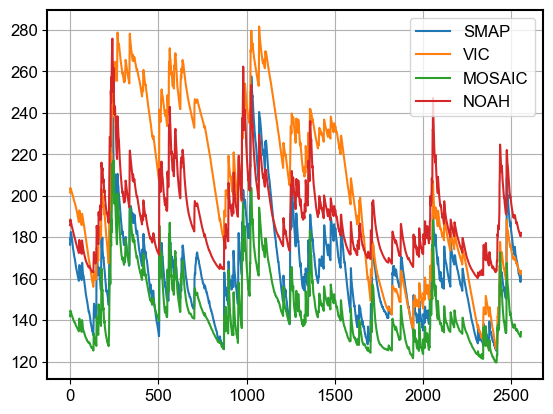

In [38]:
# Plot
fig, ax = plt.subplots()

for obs_name in ["SMAP", "VIC", "MOSAIC", "NOAH"]:
    ds_tmp = np.load(f"{project_data_path}/WBM/calibration/CONUS/{obs_name}/{obs_name}_validation.npy")
    ax.plot(ds_tmp[ix, iy, :], label=obs_name)

ax.grid()
ax.legend()
plt.show()

In [39]:
# Uncertain parameters
param_dict = {}

### Snow dynamics
param_dict['Ts'] = [-3, -1] # Snowfall threshold [C]
param_dict['Tm'] = [1, 3] # Snowmelt threshold [C]

### Soil characteristics
param_dict['wiltingp'] = [50, 200] # Wilting point [mm]
param_dict['awCap'] = [100, 500] # Available water capacity [mm/m] (mm with rootDepth of 1m)

param_dict['alpha'] = [1, 10] # affects AET []
param_dict['betaHBV'] = [1, 10] # affects runoff []

### Kc timeseries (for maize)
param_dict['Kmin'] = [0.1, 0.75]
param_dict['Kmax'] = [0.75, 1.5]
param_dict['c_lai'] = [0.1, 1]

# Store
with open(f"{project_data_path}/WBM/SA/{location}.json", 'w') as f:
    json.dump(param_dict, f)

store_params(param_dict, 1024, f"{location}_1024")
store_params(param_dict, 2048, f"{location}_2048")
store_params(param_dict, 4096, f"{location}_4096")

Parameter file already exists!
Parameter file already exists!
Parameter file already exists!


In [40]:
%%time
# Historical
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        # Output name
        save_name = f"{location}_{str(N)}_{obs}_noCC"
        # Check if done
        if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res_total.csv"):
            print(f"{save_name} already done")
        else:
            # Run it
            if N == 4096:
                store_sims = True
            else:
                store_sims = False
                
            wbm_sobol(ix=ix, iy=iy,
                      forcing=obs, eval=obs,
                      tas_delta=0., prcp_factor=1.,
                      experiment_name=location,
                      Kpet_name="gen",
                      N=N,
                      store_sims=store_sims,
                      save_name=save_name)
            print(save_name)

bigbend_1024_SMAP_noCC already done
bigbend_2048_SMAP_noCC already done
bigbend_4096_SMAP_noCC already done
bigbend_1024_NLDAS_noCC already done
bigbend_2048_NLDAS_noCC already done
bigbend_4096_NLDAS_noCC already done
CPU times: user 753 μs, sys: 40 μs, total: 793 μs
Wall time: 2.43 ms


In [41]:
%%time
# "Future"
for obs in ["SMAP", "NLDAS"]:
    # Loop through paramater multipliers
    for N in [1024, 2048, 4096]:
        for tas_delta in [-5, 2, 5, 10]:
            for prcp_factor in [0.5, 0.9, 1.1, 1.5]:
                # Output name
                save_name = f"{location}_{str(N)}_{obs}_CCtas{str(tas_delta)}prcp{str(prcp_factor)}"
                # Check if done
                if os.path.isfile(f"{project_data_path}/WBM/SA/{save_name}_res_total.csv"):
                    print(f"{save_name} already done")
                else:
                    # Run it
                    if N == 4096:
                        store_sims = True
                    else:
                        store_sims = False
                    wbm_sobol(ix=ix,
                              iy=iy,
                              forcing=obs,
                              eval=None,
                              tas_delta=tas_delta,
                              prcp_factor=prcp_factor,
                              experiment_name=location,
                              Kpet_name="gen",
                              N=N,
                              store_sims=store_sims,
                              save_name=save_name)
                    print(save_name)

/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_SMAP_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_SMAP_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_SMAP_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_1024_NLDAS_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_2048_NLDAS_CCtas10prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas-5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas-5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas-5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas-5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas2prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas2prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas2prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas2prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas5prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas5prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas5prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas5prcp1.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas10prcp0.5


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas10prcp0.9


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas10prcp1.1


/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


bigbend_4096_NLDAS_CCtas10prcp1.5
CPU times: user 1h 18min 29s, sys: 4min 10s, total: 1h 22min 39s
Wall time: 1h 23min 57s


### Plots

In [13]:
location = "bigbend"
lat, lon = location_coords[location]

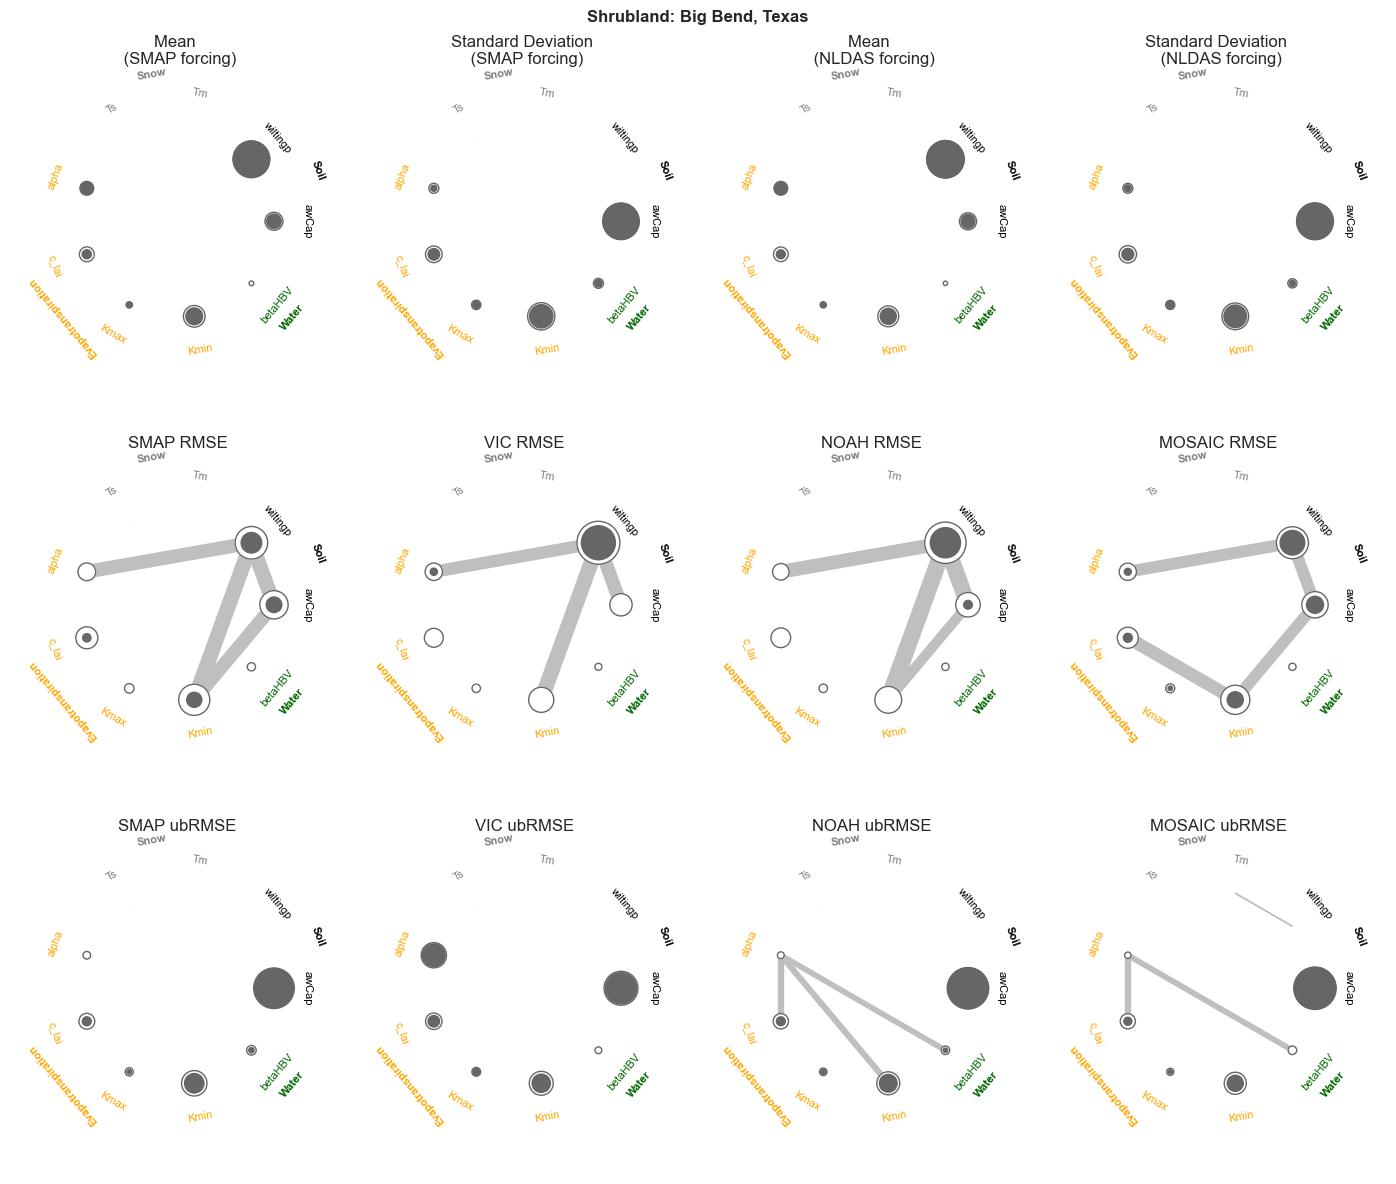

In [14]:
from utils.grouped_radial import plot_second_order_all

plot_second_order_all(location, groups_nonag, 4096, True)

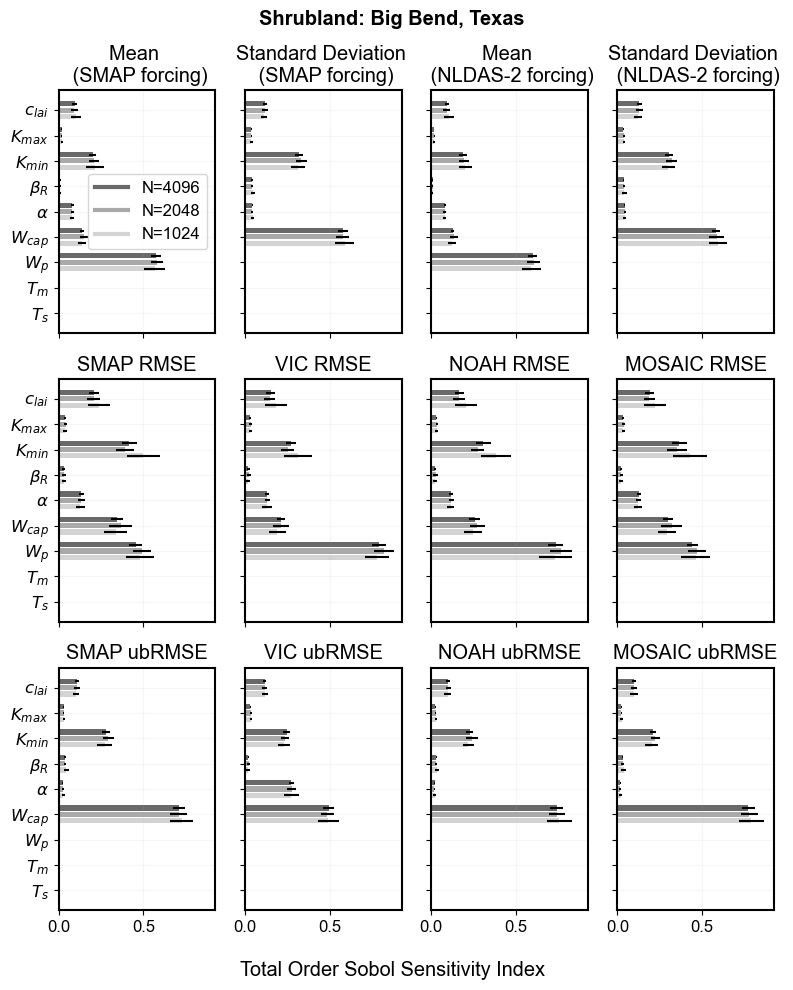

In [8]:
# Historical
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

fig, axs = plt.subplots(3,4, figsize=(8,10), sharey=True, sharex=True)

# Top row
sobol_bar_plot(location, "SMAP", "noCC", "mean", True, True, obs_colors["SMAP"], "Mean \n (SMAP forcing)", axs[0,0])
sobol_bar_plot(location, "SMAP", "noCC", "sd", True, False, obs_colors["SMAP"], "Standard Deviation \n (SMAP forcing)", axs[0,1])
sobol_bar_plot(location, "NLDAS", "noCC", "mean", True, False, "gray", "Mean \n (NLDAS-2 forcing)", axs[0,2])
sobol_bar_plot(location, "NLDAS", "noCC", "sd", True, False, "gray", "Standard Deviation \n (NLDAS-2 forcing)", axs[0,3])

# Middle row
for ido, obs_name in enumerate(obs_colors.keys()):
    sobol_bar_plot(location, obs_name, "noCC", f"rmse_{obs_name}",True, False, obs_colors[obs_name], f"{obs_name} RMSE", axs[1,ido])

# Bottom row
for ido, obs_name in enumerate(obs_colors.keys()):
    sobol_bar_plot(location, obs_name, "noCC", f"ubrmse_{obs_name}",True, False, obs_colors[obs_name], f"{obs_name} ubRMSE", axs[2,ido])

fig.supxlabel('Total Order Sobol Sensitivity Index')
fig.suptitle(location_names[location], fontweight='bold')

plt.tight_layout()

plt.savefig(f'{project_code_path}/figs/si/{location}_sobol_noCC.pdf')

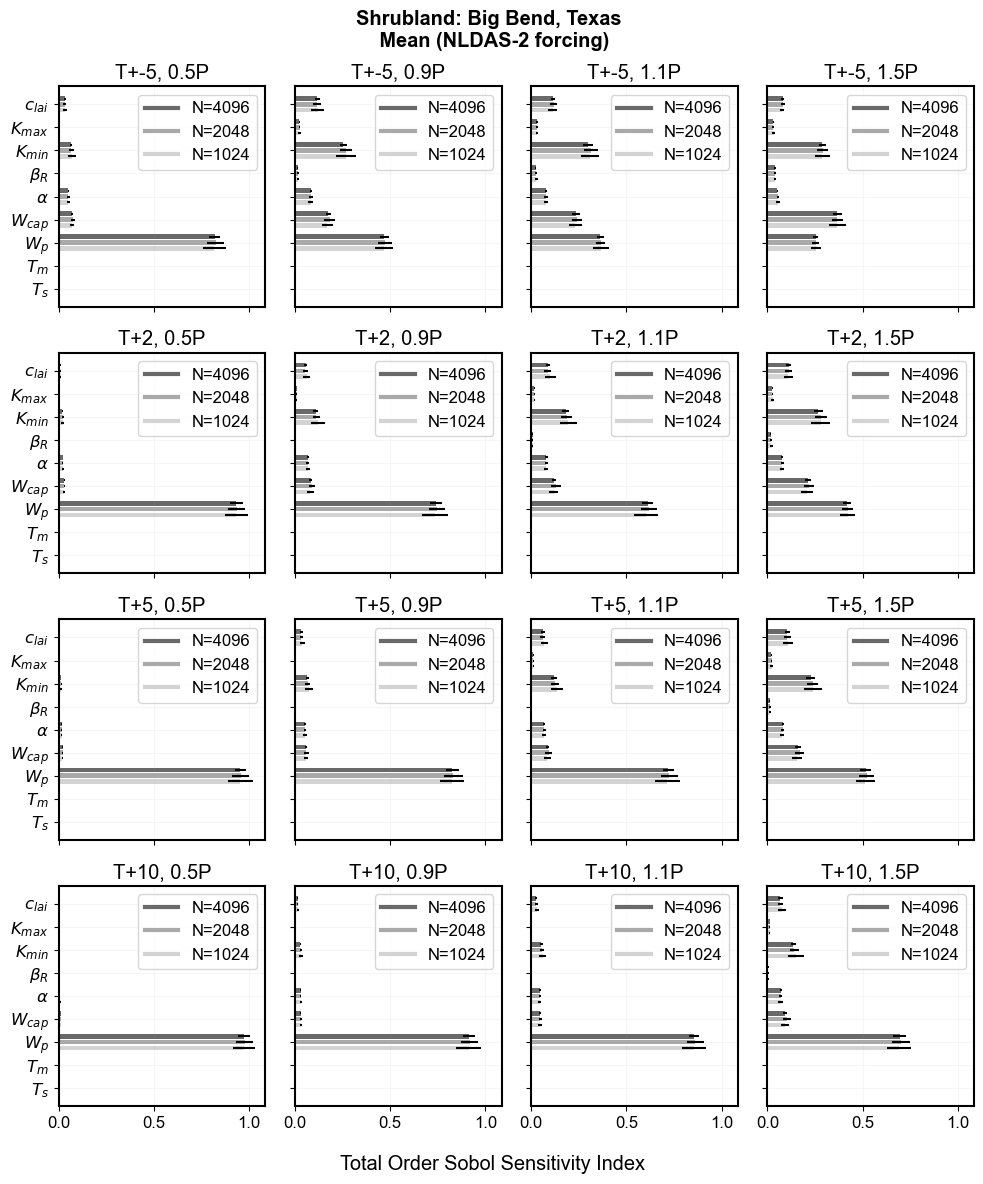

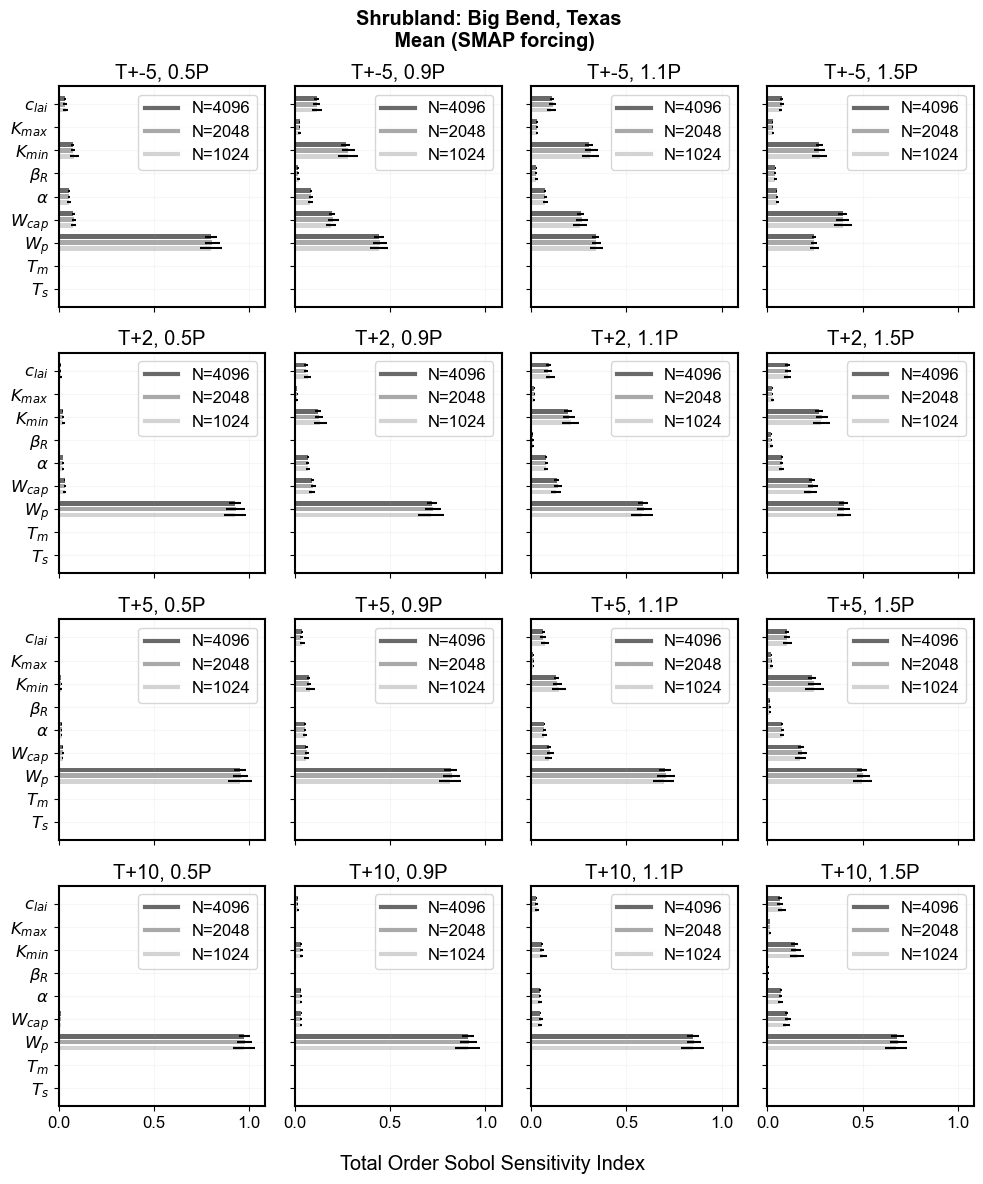

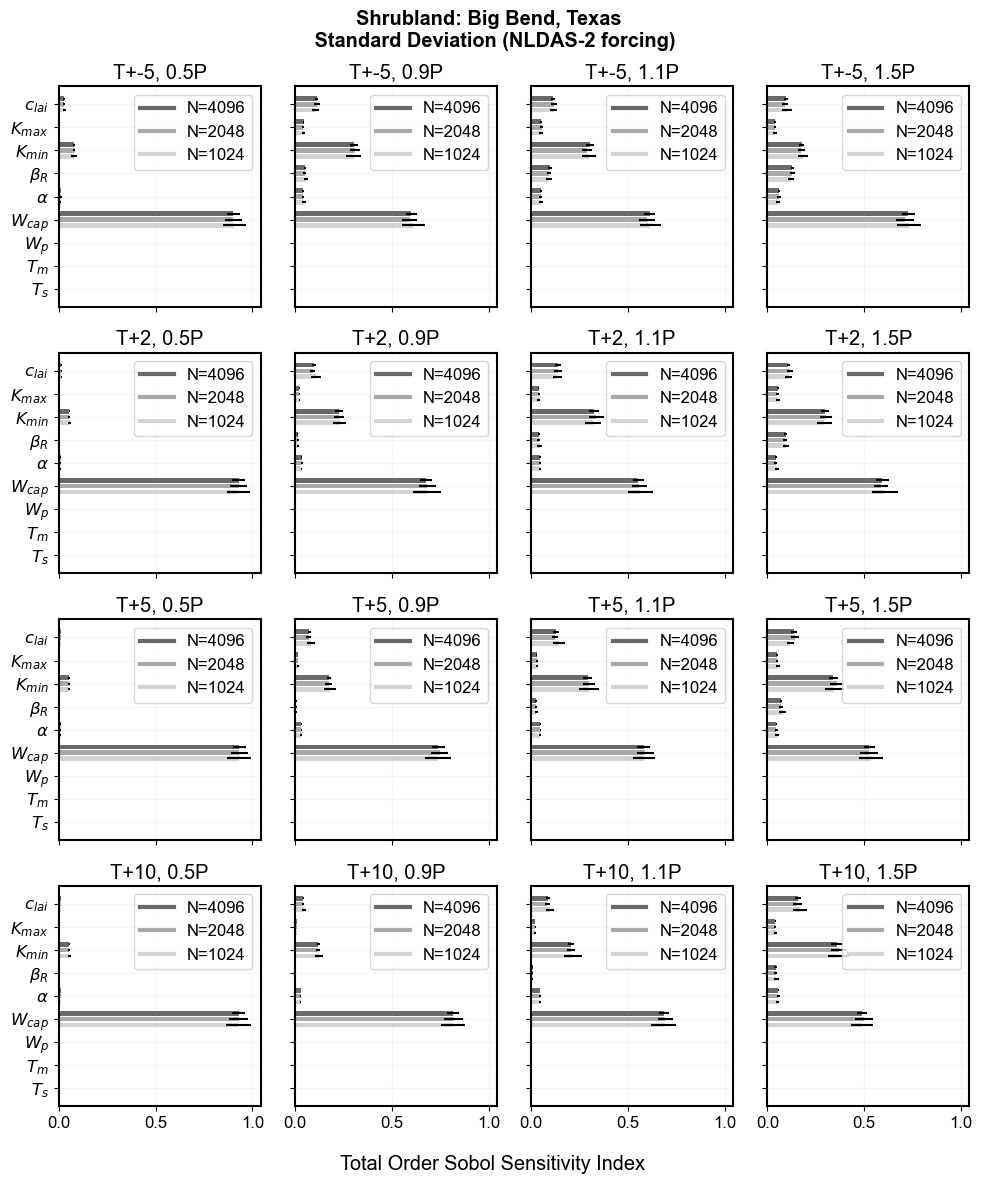

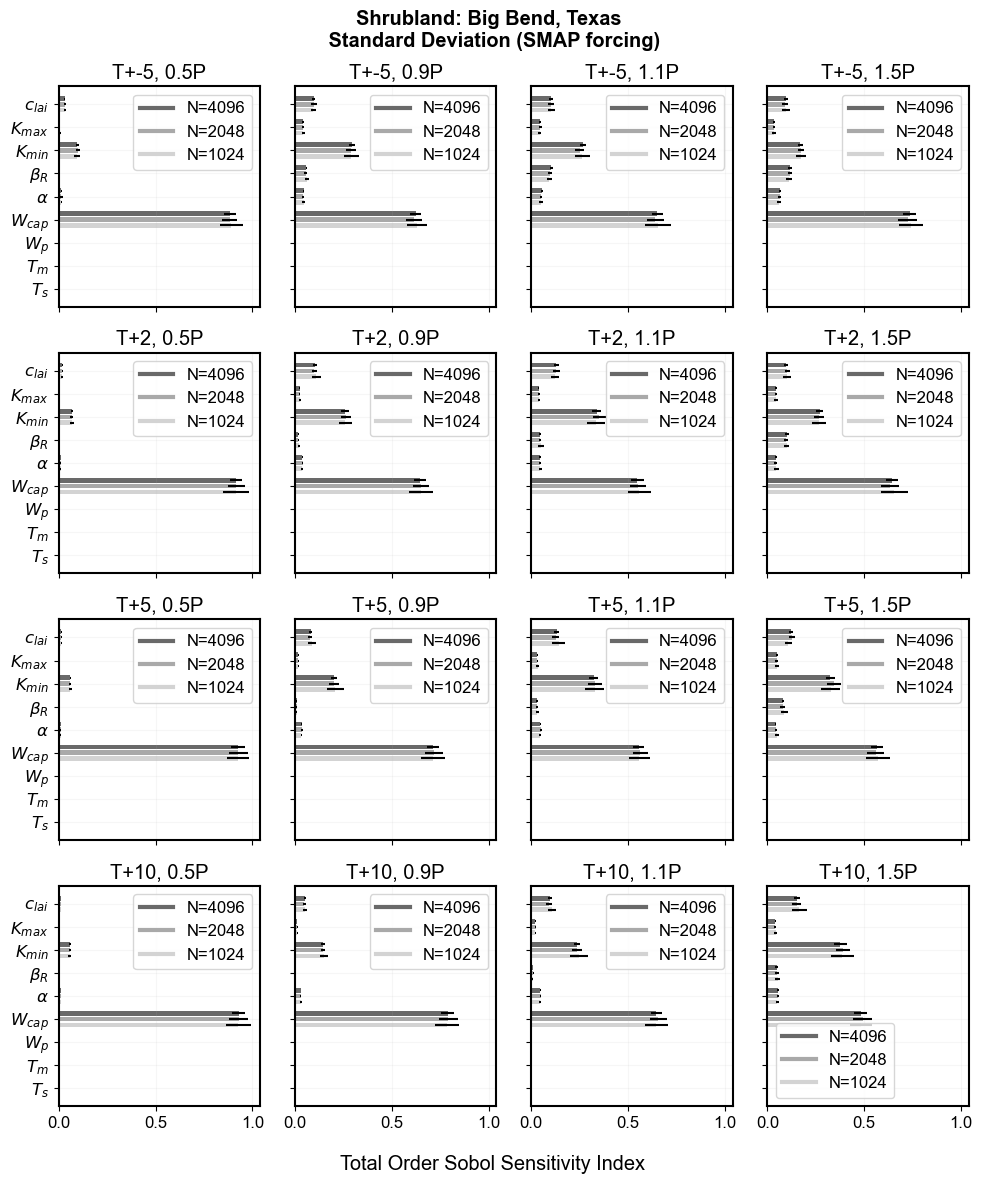

In [9]:
# Future
obs_name_dict = {'NLDAS':'NLDAS-2', 'SMAP':'SMAP'}
metric_name_dict = {'mean':'Mean', 'sd':'Standard Deviation', 'rmse': 'RMSE', 'ubrmse': 'ubRMSE'}

# Loop through metric/obs combos
for metric in ["mean", "sd"]:
    for obs_name in obs_name_dict.keys():
        # Make figure
        fig, axs = plt.subplots(4,4, figsize=(10,12), sharey=True, sharex=True)

        for idt, tas_delta in enumerate([-5, 2, 5, 10]):
            for idp, prcp_factor in enumerate([0.5, 0.9, 1.1, 1.5]):
                sobol_bar_plot(location, obs_name, f"CCtas{tas_delta}prcp{prcp_factor}", metric, True, True, None, f"T+{tas_delta}, {prcp_factor}P", axs[idt, idp])

        fig.supxlabel('Total Order Sobol Sensitivity Index')
        fig.suptitle(f"{location_names[location]} \n {metric_name_dict[metric]} ({obs_name_dict[obs_name]} forcing)", fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'{project_code_path}/figs/si/{location}_sobol_CC_{obs_name}_{metric}.pdf')

/tmp/ipykernel_1740955/2244230319.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_1740955/2244230319.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../figs/si/{location}_hindcast_stats.png', dpi=600)
/storage/home/dcl5300/miniforge3/envs/climate-stack-2024-10/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


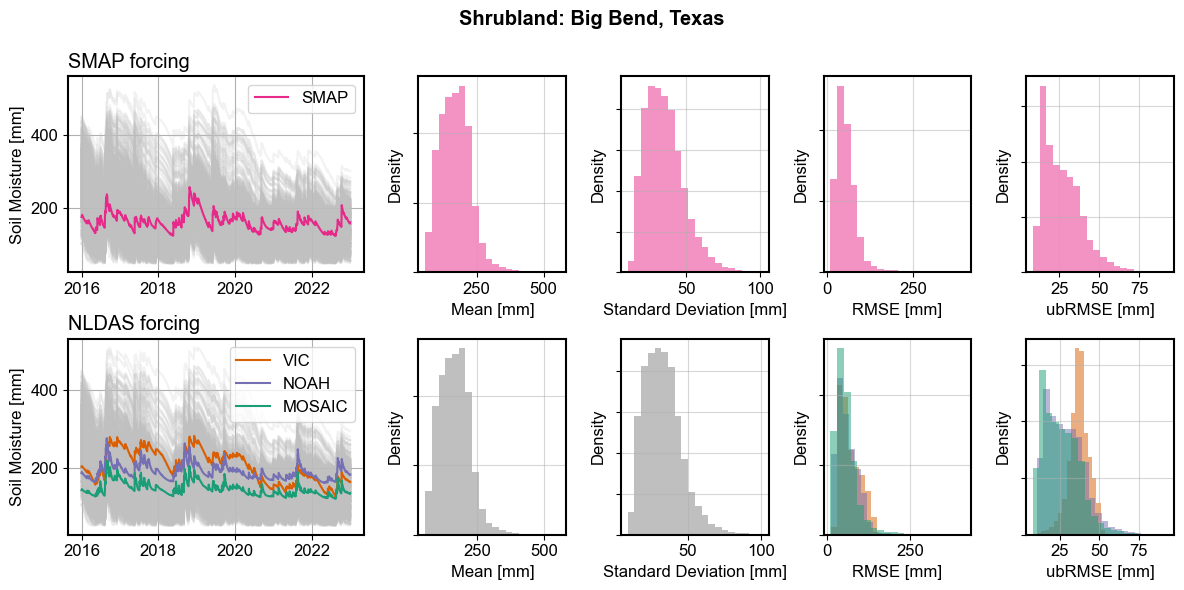

In [10]:
# Timeseries and summary stats

# Read data
npz_smap = np.load(f"{project_data_path}/WBM/SA/{location}_4096_SMAP_noCC_sim_stats.npz")
npz_nldas = np.load(f"{project_data_path}/WBM/SA/{location}_4096_NLDAS_noCC_sim_stats.npz")

smap_sims = npz_smap['sims']
nldas_sims = npz_nldas['sims']

# Plot details
times = xr.cftime_range(start='2016-01-01', end='2022-12-31', calendar='365_day')
stat_name_dict = {'mean':'Mean [mm]', 'sd':'Standard Deviation [mm]', 'rmse': 'RMSE [mm]', 'ubrmse': 'ubRMSE [mm]'}

# Start plot
fig, axs = plt.subplots(2, 5, figsize=(12,6), width_ratios = [2,1,1,1,1])
fig.suptitle(location_names[location], fontweight='bold')

## SMAP
# Timeseries
ax = axs[0,0]
ax.set_title('SMAP forcing', loc='left')
for i in range(1, smap_sims.shape[0], 100):
    ax.plot(times, smap_sims[i, :], color='silver', alpha=0.2)

plot_timeseries(location_coords[location], ['SMAP'], False, False, ax, True)

# Stats
for ids, stat in enumerate(['mean', 'sd', 'rmse', 'ubrmse']):
    ax = axs[0,1+ids]
    data = npz_smap[f'SMAP_{stat}'] if 'rmse' in stat else npz_smap[stat]
    ax.hist(data, bins=20, color=obs_colors['SMAP'], alpha=0.5)
    ax.set_xlabel(stat_name_dict[stat])
    ax.set_ylabel('Density')
    ax.set_yticklabels('')
    ax.grid(alpha=0.5)
    
## NLDAS
# Timeseries
ax = axs[1,0]
ax.set_title('NLDAS forcing', loc='left')
for i in range(1, nldas_sims.shape[0], 100):
    ax.plot(times, nldas_sims[i, :], color='silver', alpha=0.2)

obs_to_plot = ['VIC', 'NOAH', 'MOSAIC']
plot_timeseries(location_coords[location], obs_to_plot, False, False, ax, True)

# Stats
for ids, stat in enumerate(['mean', 'sd']):
    ax = axs[1,1+ids]
    ax.hist(npz_nldas[stat], bins=20, alpha=0.5, color='gray')
    ax.set_xlabel(stat_name_dict[stat])
    ax.set_ylabel('Density')
    ax.set_yticklabels('')
    ax.grid(alpha=0.5)
        
for ids, stat in enumerate(['rmse', 'ubrmse']):
    for obs_name in obs_to_plot:
        ax = axs[1,3+ids]
        ax.hist(npz_nldas[f'{obs_name}_{stat}'], bins=20, alpha=0.5, color=obs_colors[obs_name])
        ax.set_xlabel(stat_name_dict[stat])
        ax.set_ylabel('Density')
        ax.set_yticklabels('')
        ax.grid(alpha=0.5)
        
plt.tight_layout()
plt.savefig(f'../figs/si/{location}_hindcast_stats.png', dpi=600)

# Paper plot: Figure 3

In [34]:
# Info
metrics_to_include = ['mean_SMAP', 'sd_SMAP', 
                      'mean_NLDAS', 'sd_NLDAS', 
                      'rmse_SMAP', 'rmse_VIC', 'rmse_NOAH', 'rmse_MOSAIC',
                      'ubrmse_SMAP', 'ubrmse_VIC', 'ubrmse_NOAH', 'ubrmse_MOSAIC']

ylabels = ['Mean (SMAP forcing)', 'Std. Dev. (SMAP forcing)',
          'Mean (NLDAS forcing)', 'Std. Dev. (NLDAS forcing)',
          'SMAP RMSE', 'VIC RMSE', 'NOAH RMSE', 'MOSAIC RMSE',
          'SMAP ubRMSE', 'VIC ubRMSE', 'NOAH ubRMSE', 'MOSAIC ubRMSE']

# Colors
colors_snow = ["#C6C6C6","#919191"]
colors_soil = ["#3669AD","#BAB3F1"]
colors_alpha = ['#C2554A']
colors_beta = ['#FCA78D']
colors_ag_pet = ["#134B42","#265737","#3A652A","#52741C","#71870B","#969206","#C5AE32","#E7CD68"]
colors_gen_pet = ["#A66694","#D486AD","#D5B2CD"]

colors_ag = colors_snow + colors_soil + colors_alpha + colors_beta + colors_ag_pet + colors_gen_pet
colors_gen = colors_snow + colors_soil + colors_alpha + colors_beta + colors_gen_pet

# Params
param_names = ['$T_s$', '$T_m$',
               '$W_{wp}$', '$W_{cap}$',
               r'$\alpha$', r'$\beta_R$',
               '$GS_{start}$', '$GS_{end}$', '$L_{ini}$', '$L_{dev}$', '$L_{mid}$', '$Kc_{ini}$', '$Kc_{mid}$', '$Kc_{end}$',
                '$K_{min}$','$K_{max}$', '$c_{lai}$']

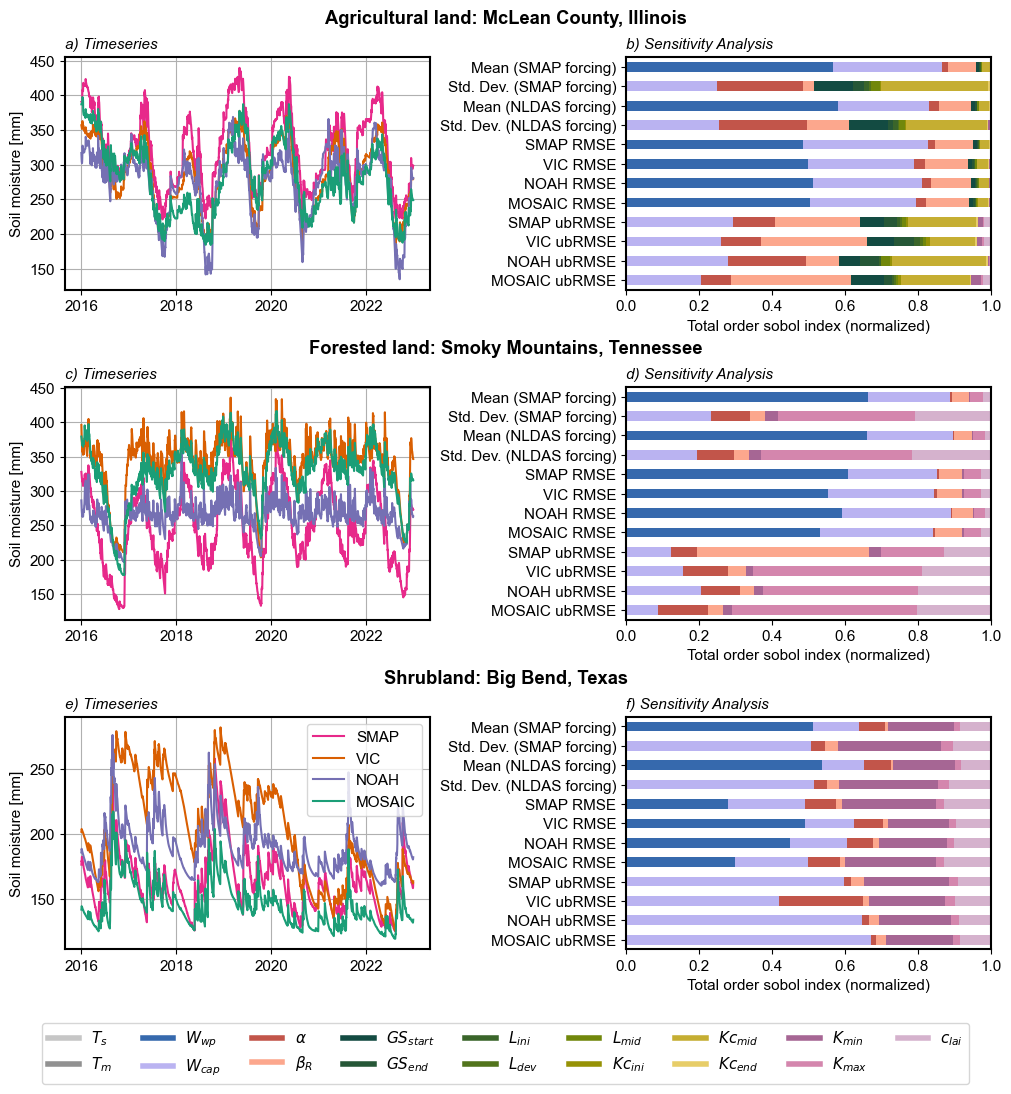

In [35]:
fig = plt.figure(layout='constrained', figsize=(10,10.5))
subfigs = fig.subfigures(4, 1, hspace=0.1, height_ratios = [5,5,5,1])

# McLean
location = 'mclean'
subfigs[0].suptitle(f'{location_names[location]}', fontweight='bold', y=1.08)
axs = subfigs[0].subplots(1, 2)
plot_timeseries(location_coords[location], obs_names, False, False,  axs[0], False, 'a) Timeseries')
make_sobol_plot_normalized(location, axs[1], 'b) Sensitivity Analysis', colors_ag)

# Smoky
location = 'smoky'
axs = subfigs[1].subplots(1, 2)
subfigs[1].suptitle(f'{location_names[location]}', fontweight='bold', y=1.08)
plot_timeseries(location_coords[location], obs_names, False, False, axs[0], False, 'c) Timeseries')
make_sobol_plot_normalized(location, axs[1], 'd) Sensitivity Analysis', colors_gen)

# Big Bend
location = 'bigbend'
subfigs[2].suptitle(f'{location_names[location]}', fontweight='bold', y=1.08)
axs = subfigs[2].subplots(1, 2)
plot_timeseries(location_coords[location], obs_names, False, False, axs[0], True, 'e) Timeseries')
make_sobol_plot_normalized(location, axs[1], 'f) Sensitivity Analysis', colors_gen)

# Legend
ax = subfigs[3].subplots(1, 1)
custom_lines = [Line2D([0], [0], color=color, lw=4) for color in colors_ag]
ax.legend(custom_lines, param_names, ncol = 9, loc='center', fontsize=11)
ax.set_axis_off()

plt.savefig('../figs/main/fig3_initial_sa.pdf', bbox_inches='tight')